In [2]:
!pip install datasets
!pip install sentence_transformers
!pip install pandas
!pip install --upgrade transformers
!pip install torchmetrics --upgrade
!pip install nbformat
!pip install git+https://github.com/openai/CLIP.git
!pip install bert_score
!pip install diffusers

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-feqpsi18
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-feqpsi18
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done


In [3]:

from PIL import Image
import torch
import os
from datasets import load_dataset
from datasets.utils.file_utils import get_datasets_user_agent
import requests
import numpy as np
import pandas as pd
import json
import clip
# from natsort import natsorted
from transformers import Blip2Processor, Blip2ForConditionalGeneration
from sentence_transformers import SentenceTransformer, util
from torchmetrics.multimodal.clip_score import CLIPScore
USER_AGENT = get_datasets_user_agent()
from bert_score import score
from diffusers import StableDiffusionPipeline
from tqdm import tqdm



In [4]:



def calculate_clip_score(image, correct_prompt, revers_prompt, model, preprocess, device):
    try:
        # Ensure image is preprocessed and on the right device
        image_input = preprocess(image).unsqueeze(0).to(device)

        # Encode image features
        with torch.no_grad():
            image_features = model.encode_image(image_input)

            # Encode text prompts
            text_tokens = clip.tokenize([correct_prompt, revers_prompt]).to(device)
            text_features = model.encode_text(text_tokens)

            # Normalize the features
            image_features /= image_features.norm(dim=-1, keepdim=True)
            text_features /= text_features.norm(dim=-1, keepdim=True)

            # Calculate cosine similarities
            correct_score = torch.cosine_similarity(image_features, text_features[0].unsqueeze(0)).item()
            reverse_score = torch.cosine_similarity(image_features, text_features[1].unsqueeze(0)).item()

        # Clear GPU memory if using GPU
        if torch.cuda.is_available() and device == 'cuda':
            torch.cuda.empty_cache()

        return correct_score * 100, reverse_score * 100

    except Exception as e:
        print(f"An error occurred: {e}")
        return None, None  # Return default values or handle the error appropriately


In [5]:
def calculate_blip_2(image, prompt, processor ,model, device):
        img_inputs = processor(images=image, return_tensors="pt").to(device)
        if next(model.parameters()).device != device:
            model.to(device)
        # Generate image features
        with torch.no_grad():
          generated_ids = model.generate(**img_inputs)

        generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()
      # Compare token lengths (optional)
        generated_tokens = generated_text.split()  # Simple whitespace tokenization
        prompt_tokens = prompt.split()


        # Compute BERTScore for semantic similarity
        # Wrap the texts in lists as required by BERTScore
        P, R, F1 = score([generated_text], [prompt], lang="en", rescale_with_baseline=True)
        if torch.cuda.is_available() and device == 'cuda':
            torch.cuda.empty_cache()
        return F1, generated_text


In [17]:

def csv_to_json (csv_file_path , json_file_path):
    df = pd.read_csv(csv_file_path)
    df.to_json(json_file_path, orient='records', lines=True)
    print(f"CSV file has been converted to JSON and saved at {json_file_path}")
    return json_file_path

In [13]:
import json
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns
import csv
import os

def plot_clip_scores(clip_scores):
    # Count positive and negative scores
    positive_count = sum(1 for score in clip_scores if score > 0)
    negative_count = sum(1 for score in clip_scores if score < 0)
    total = positive_count +  negative_count
    # Data for plotting
    categories = ['Positive', 'Negative']
    counts = [positive_count, negative_count]

    # Create bar plot
    plt.bar(categories, counts, color=['green', 'red'])
    plt.xlabel('Score Type')
    plt.ylabel('Count')
    plt.title(f'Number of Positive diff scores is {positive_count} out of  {total}')
    plt.show()



def create_csv(file_name, data_list, save_dir='.'):
    """
    Creates a CSV file from a list of dictionaries.

    :param file_name: Name of the output CSV file (without extension)
    :param data_list: List of dictionaries containing the data
    :param save_dir: Directory where the CSV file will be saved (default is current directory)
    """
    # Ensure the file name has a .csv extension
    if not file_name.endswith('.csv'):
        file_name += '.csv'

    # Full path to the output file
    file_path = os.path.join(save_dir, file_name)

    # Check if data_list is not empty and get the fieldnames from the first dictionary
    if data_list:
        fieldnames = data_list[0].keys()
    else:
        raise ValueError("Data list is empty")

    # Writing to csv file
    with open(file_path, 'w', newline='', encoding='utf-8') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

        # Write the header
        writer.writeheader()

        # Write the data
        for row in data_list:
            writer.writerow(row)

    print(f"CSV file '{file_path}' created successfully.")


def evaluation(save_dir, json_file , metric= "clip", img_col = 'file_name', text_col='text', revers_col = "reverse_text", output_file_name = 'clip_output'):
    # Open the file in write mode ('w')
    print_data=[]
    total_blip_score =[]
    total_reverse_blip_score =[]
    total_diff_blip =[]
    blip_count =0
    total_clip_score =[]
    total_reverse_clip_score =[]
    total_diff_clip =[]
    clip_count =0
    output_clip_data = []
    output_blip_data = []
    with open(json_file, 'r', encoding='utf-8') as file:
        data = json.load(file)  # Load the entire JSON data
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using {device}")
    # Iterate over each entry in the array
    if(metric in ("clip", "both")):
      print(f"Metric used is CLIP Score using {device}")
      print_data.append(f"Metric used is CLIP Score using {device}")
      model, preprocess = clip.load("ViT-B/32", device=device)
    if(metric in ("blip" , "both")):
      print(f"Metric used is BLIP Score")
      print_data.append(f"Metric used is BLIP Score")
      processor = Blip2Processor.from_pretrained("Salesforce/blip2-flan-t5-xl")
      model = Blip2ForConditionalGeneration.from_pretrained("Salesforce/blip2-flan-t5-xl")
    for entry in data:
        img_path = os.path.join(save_dir, entry[img_col])
        caption = entry[text_col]
        revers_caption = entry[revers_col]
        if img_path.endswith(".jpg") or img_path.endswith(".png"):
            img = Image.open(img_path)
        if metric == "clip":
            score , reverse_score= calculate_clip_score(img, caption, revers_caption, model, preprocess, device )
            diff = 10*(score - reverse_score)
            print(f"Image: {img_path}, Caption: {caption}, CLIP Score: {score}, reverse caption {revers_caption}, reverse score {reverse_score}, diff*10 {diff}")
            print_data.append(f"Image: {img_path}, Caption: {caption}, CLIP Score: {score}, reverse caption {revers_caption}, reverse score {reverse_score}, diff*10 {diff}")
            output_clip_data.append({'Image': entry[img_col],'Caption': caption,'Score': score, 'reverse caption':revers_caption ,'reverse score': reverse_score,'diff*10': diff})
            total_clip_score.append(score)
            total_reverse_clip_score.append(reverse_score)
            total_diff_clip.append(diff)
            clip_count += 1
        if metric == "blip":
            blip_score_dec, generated_caption = calculate_blip_2(img,caption,processor,model,device)
            blip_reverse_score_dec, reverse_generated_caption = calculate_blip_2(img,revers_caption,processor,model,device)
            blip_score = 100*blip_score_dec.item()
            blip_reverse_score = 100*blip_reverse_score_dec.item()
            blip_diff = 10*(blip_score - blip_reverse_score)
            total_blip_score.append(blip_score)
            total_reverse_blip_score.append(blip_reverse_score)
            total_diff_blip.append(blip_diff)
            blip_count += 1
            print(f"Image: {img_path}, Caption: {caption}, Generated Caption {generated_caption} BLIP2 Score: {blip_score}, reverse caption: {revers_caption} , reverse BLIP score {blip_reverse_score}, diff*10 {blip_diff}")
            output_blip_data.append({'Image': entry[img_col],'Caption': caption,'Score': blip_score, 'reverse caption':revers_caption ,'reverse score': blip_reverse_score, 'diff*10': blip_diff})
            print_data.append(f"Image: {img_path}, Caption: {caption}, Generated Caption {generated_caption} BLIP2 Score: {blip_score}, reverse caption: {revers_caption} , reverse BLIP score {blip_reverse_score} , diff*10 {blip_diff} ")
        # Calculate averages
    if clip_count > 0:
        avg_clip_score = np.mean(total_clip_score)
        avg_reverse_clip_score = np.mean(total_reverse_clip_score)
        avg_diff_clip = np.mean(total_diff_clip)
        # Calculate variance
        var_clip_score= np.var(total_clip_score)
        var_reverse_clip_score = np.var(total_reverse_clip_score)
        var_diff_clip = np.var(total_diff_clip)
        # Create the box plot
        all_clip_scores = [total_clip_score, total_reverse_clip_score, total_diff_clip]
        plt.figure(figsize=(10, 6))
        sns.boxplot(data=all_clip_scores)
        plt.xticks(ticks=range(len(all_clip_scores)), labels=['CLIP Score', 'Reverse CLIP Score', 'CLIP Diffx10'])
        plt.ylabel('Score')
        plt.title('Distribution of Image-Caption Pair Scores')
        plt.grid(True)
        plt.savefig(f'{save_dir}/clip_distribution.png')  # You can change the file format by changing the extension
        plt.show()
        plt.close()  # Close the plot to free up memory
        print(f"CLIP Score: Avrage:{avg_clip_score} var: {var_clip_score},  Reverse CLIP Score: avg:{avg_reverse_clip_score} var:{var_reverse_clip_score},  CLIP Diff: avg:{avg_diff_clip} var: {var_diff_clip}")
        print_data.append(f"CLIP Score: Avrage:{avg_clip_score} var: {var_clip_score},  Reverse CLIP Score: avg:{avg_reverse_clip_score} var:{var_reverse_clip_score},  CLIP Diff: avg:{avg_diff_clip} var: {var_diff_clip}")
        plot_clip_scores(total_diff_clip)
        create_csv(output_file_name,output_clip_data,save_dir)
    if blip_count > 0:
        avg_blip_score = np.mean(total_blip_score)
        avg_reverse_blip_score = np.mean(total_reverse_blip_score)
        avg_diff_blip = np.mean(total_diff_blip)
        # Calculate variance
        var_blip_score= np.var(total_blip_score)
        var_reverse_blip_score = np.var(total_reverse_blip_score)
        var_diff_blip = np.var(total_diff_blip)
        # Create the box plot
        all_blip_scores = [total_blip_score, total_reverse_blip_score, total_diff_blip]
        plt.figure(figsize=(10, 6))
        sns.boxplot(data=all_blip_scores)
        plt.xticks(ticks=range(len(all_blip_scores)), labels=['BLIP Score', 'Reverse BLIP Score', 'BLIP Diffx100'])
        plt.ylabel('Score')
        plt.title('Distribution of Image-Caption Pair Scores')
        plt.grid(True)
        plt.savefig(f'{save_dir}/blip_distribution.png')  # You can change the file format by changing the extension
        plt.show()
        plt.close()  # Close the plot to free up memory
        print(f"BLIP Score: Avrage:{avg_blip_score} var: {var_blip_score},  Reverse BLIP Score: avg:{avg_reverse_blip_score} var:{var_reverse_blip_score},  BLIP Diff: avg:{avg_diff_blip} var: {var_diff_blip}")
        print_data.append(f"BLIP Score: Avrage:{avg_blip_score} var: {var_blip_score},  Reverse BLIP Score: avg:{avg_reverse_blip_score} var:{var_reverse_blip_score}, BLIP Diff: avg:{avg_diff_blip} var: {var_diff_blip}")
        plot_clip_scores(total_diff_blip)
        create_csv(output_file_name,output_blip_data,save_dir)
    with open(f'{save_dir}/{output_file_name}.txt', 'w', encoding='utf-8') as file:
      file.write("\n".join(print_data))  # Join the list into a string with line breaks
    torch.cuda.empty_cache()



Code for revers caption


In [7]:
!python -m spacy download en_core_web_trf

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 457.4/457.4 MB 1.9 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_trf')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [8]:

!pip install spacy-transformers

  Using cached transformers-4.36.2-py3-none-any.whl.metadata (126 kB)
  Using cached tokenizers-0.15.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.7 kB)
Using cached transformers-4.36.2-py3-none-any.whl (8.2 MB)
Using cached tokenizers-0.15.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (3.6 MB)
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.20.0
    Uninstalling tokenizers-0.20.0:
      Successfully uninstalled tokenizers-0.20.0
  Attempting uninstall: transformers
    Found existing installation: transformers 4.45.1
    Uninstalling transformers-4.45.1:
      Successfully uninstalled transformers-4.45.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sentence-transformers 3.1.1 requires transformers<5.0.0,>=4.38.0, but you have transformers 4.36.2 which is incompatible.


In [9]:
import spacy
import spacy_transformers
from google.colab import drive
import os
import pandas as pd
import json

In [10]:
# Load spaCy's English model
nlp = spacy.load("en_core_web_trf")

def get_full_phrase(token):
    """Helper function to return the full phrase for a given token, including its modifiers."""
    # Collect the token and its modifiers
    phrase_tokens = [token]

    # Add left children (modifiers, determiners, etc.) and sort by token position
    phrase_tokens.extend(list(token.lefts))

    # Sort tokens by their position in the sentence to maintain proper order
    phrase_tokens = sorted(phrase_tokens, key=lambda x: x.i)

    # Return the full phrase
    return ' '.join([t.text for t in phrase_tokens])

def identify_roles(sentence):
    doc = nlp(sentence)
    agent = ""
    patient = ""
    action = ""
    remainder = []

    agent_tokens = set()
    patient_tokens = set()
    action_token = None

    for token in doc:
        # Identify subject (agent) and object (patient)
        if token.dep_ == "nsubj":  # Nominal subject (agent)
            agent = get_full_phrase(token)
            agent_tokens.update([token] + list(token.lefts))  # Collect tokens for agent
        elif token.dep_ == "dobj":  # Direct object (patient)
            patient = get_full_phrase(token)
            patient_tokens.update([token] + list(token.lefts))  # Collect tokens for patient
        elif token.pos_ == "VERB":  # Action (verb)
            action = token.text
            action_token = token  # Store the action token
        else:
            remainder.append(token)  # Collect other tokens as remainder

    # Exclude agent, patient, and action tokens from remainder
    remainder = [token.text for token in remainder if token not in agent_tokens and token not in patient_tokens and token != action_token]

    # Remove any period ('.') from the remainder list
    remainder = [token for token in remainder if token != '.']

    # Return agent, action, patient, and the remainder
    return agent, action, patient, remainder

def switch_roles(sentence):
    agent, action, patient, remainder = identify_roles(sentence)

    # Capitalize first letter and adjust singular/plural of verb if needed
    if agent and patient:
        remainder_text = ' '.join(remainder).strip()

        # Check if there's a remainder and construct the sentence accordingly
        if remainder_text:
            switched_sentence = f"{patient.capitalize()} {action}{'s' if not action.endswith('s') else ''} {agent.lower()} {remainder_text}."
        else:
            switched_sentence = f"{patient.capitalize()} {action}{'s' if not action.endswith('s') else ''} {agent.lower()}."

        return switched_sentence
    else:
        return "Failed"

/usr/local/lib/python3.10/dist-packages/thinc/shims/pytorch.py:253: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(filelike, map_location=dev

#Model Evaluation:
 Receive model save dir and caption.txt
 generate images from caption.txt, save them into save_dir and return Json with image, caption and revers caption for evaluation function

In [11]:
def evaluate_model(model_id, captions_txt, save_dir, json_caption, seed=42):

    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    # Load the Stable Diffusion model
    image_data = []
    # Read captions from the .txt file
    if(captions_txt != "none"):
      with open(captions_txt, 'r') as f:
          captions = f.readlines()
    torch.manual_seed(seed)

    # Remove any leading/trailing whitespace characters
    if (json_caption != "none"):
      df = pd.read_csv(json_caption)
      captions = df["caption_0"]  # Load the entire JSON data
      reverse_captions = df["caption_1"]
    else:
      captions = [caption.strip() for caption in captions]
      reverse_captions = []

    sd_model = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16)
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Evaluating using {device}")

    for i, entry in enumerate(captions):
        if (json_caption != "none"):
          caption = entry
          reverse_caption = reverse_captions[i]
        else:
          caption = entry
          reverse_caption = switch_roles(caption)  # Example of reverse captioning


        sd_model = sd_model.to(device)
        # Generate image from caption
        with torch.no_grad():
            generator = torch.Generator(device).manual_seed(seed)
            image = sd_model(caption, generator=generator).images[0]



        # Save the image
        filename = f"image_{i}_seed_{seed}.png"
        filepath = os.path.join(save_dir, filename)
        image.save(filepath)


        if(reverse_caption != 'Failed'):
            # Append data to list
            image_data.append({"file_name": filename,"text": caption,"reverse_text": reverse_caption})
        else:
           print(f"Warning: Unable to reverse {caption}")

    # Save image data to JSON file
    json_file = os.path.join(save_dir, "image_data.json")
    with open(json_file, 'w') as f:
        json.dump(image_data, f, ensure_ascii=False, indent=4)

    if torch.cuda.is_available() and device == 'cuda':
      torch.cuda.empty_cache()
    return json_file

#Relevant For collab

In [12]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


This code use the original base model to generate images from our benchmark list
It saved in json file the image name, caption and reverse caption (generated fro caption using the function we used in the dataset filtering)


In [ ]:
current_dir = f'/content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation'
base_model_id  = "stabilityai/stable-diffusion-2-1-base"  # Adjust model ID as needed
captions_txt = f'{current_dir}/benchmark.txt'
save_dir = [None] * 4
caption_csv = "none"
for i in range(4):
  seed_base =41
  save_dir[i] = f'{current_dir}/base_evaluation_{i}'
  json_file = evaluate_model(base_model_id, captions_txt, save_dir[i], caption_csv , seed = seed_base+i )


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  


Evaluating using cuda


/usr/local/lib/python3.10/dist-packages/thinc/shims/pytorch.py:114: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(self._mixed_precision):


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Evaluating using cuda


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Evaluating using cuda


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Evaluating using cuda


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

In [37]:
torch.cuda.empty_cache()

#Incase Images are already generated, you can use this block to set directory where the images are saved and path to json file

Using cuda
Metric used is CLIP Score using cuda
Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_0/image_0_seed_41.png, Caption: A dog giving a present to a man., CLIP Score: 34.130859375, reverse caption A present givings a dog to a man., reverse score 30.2734375, diff*10 38.57421875
Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_0/image_1_seed_41.png, Caption: A dolphin rescuing a swimmer., CLIP Score: 28.515625, reverse caption A swimmer rescuings a dolphin., reverse score 27.24609375, diff*10 12.6953125
Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_0/image_3_seed_41.png, Caption: A soldier delivering a message to a pigeon., CLIP Score: 36.9873046875, reverse caption A message deliverings a soldier to a pigeon., reverse score 34.1796875, diff*10 28.076171875
Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/e

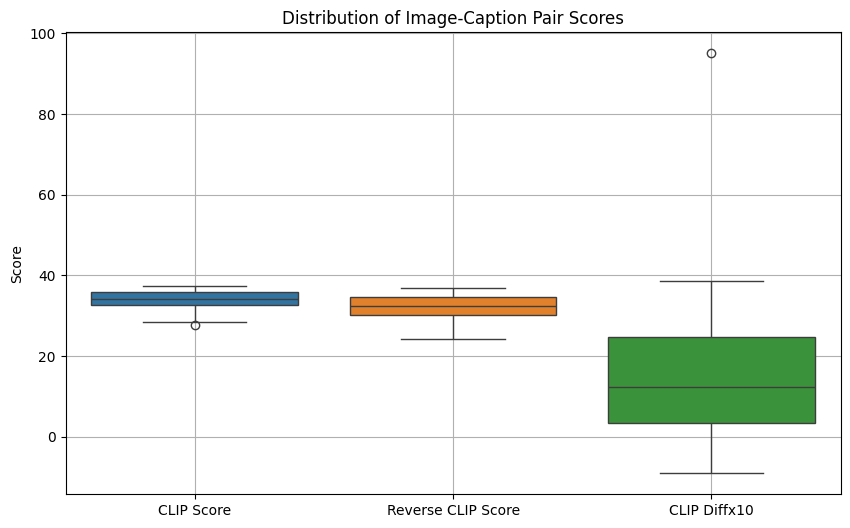

CLIP Score: Avrage:33.75108506944444 var: 8.141015782768344,  Reverse CLIP Score: avg:32.01836480034722 var:12.694770631230906,  CLIP Diff: avg:17.32720269097222 var: 502.2990574807297


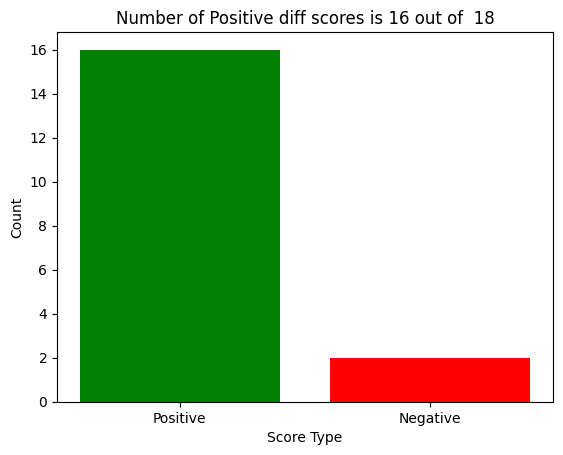

CSV file '/content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_0/clip_output.csv' created successfully.
Using cuda
Metric used is CLIP Score using cuda
Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_1/image_0_seed_42.png, Caption: A dog giving a present to a man., CLIP Score: 32.470703125, reverse caption A present givings a dog to a man., reverse score 29.7119140625, diff*10 27.587890625
Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_1/image_1_seed_42.png, Caption: A dolphin rescuing a swimmer., CLIP Score: 28.3935546875, reverse caption A swimmer rescuings a dolphin., reverse score 26.8798828125, diff*10 15.13671875
Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_1/image_3_seed_42.png, Caption: A soldier delivering a message to a pigeon., CLIP Score: 37.6220703125, reverse caption A message de

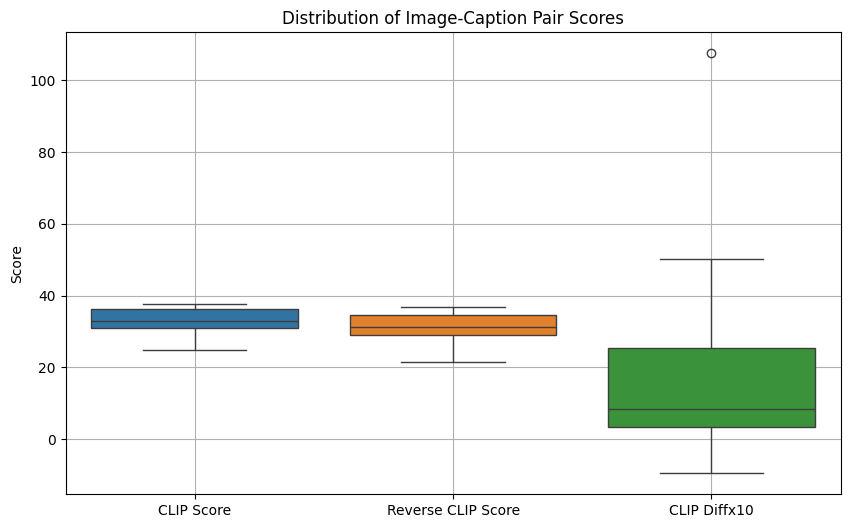

CLIP Score: Avrage:33.20244683159722 var: 12.263365457823248,  Reverse CLIP Score: avg:31.42428927951389 var:17.129974324762085,  CLIP Diff: avg:17.781575520833332 var: 687.7548164791532


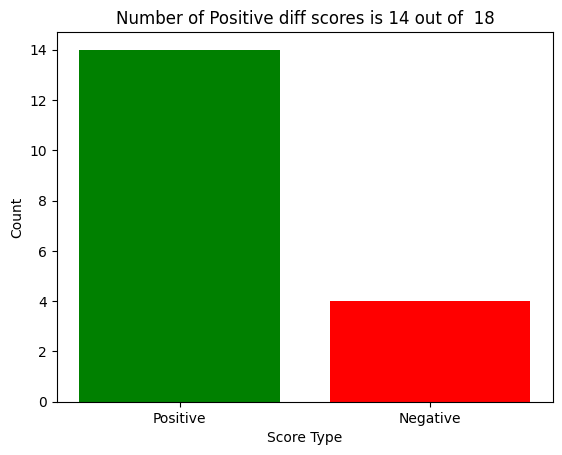

CSV file '/content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_1/clip_output.csv' created successfully.
Using cuda
Metric used is CLIP Score using cuda
Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_2/image_0_seed_43.png, Caption: A dog giving a present to a man., CLIP Score: 29.5166015625, reverse caption A present givings a dog to a man., reverse score 27.9296875, diff*10 15.869140625
Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_2/image_1_seed_43.png, Caption: A dolphin rescuing a swimmer., CLIP Score: 28.3935546875, reverse caption A swimmer rescuings a dolphin., reverse score 27.001953125, diff*10 13.916015625
Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_2/image_3_seed_43.png, Caption: A soldier delivering a message to a pigeon., CLIP Score: 36.4501953125, reverse caption A message deli

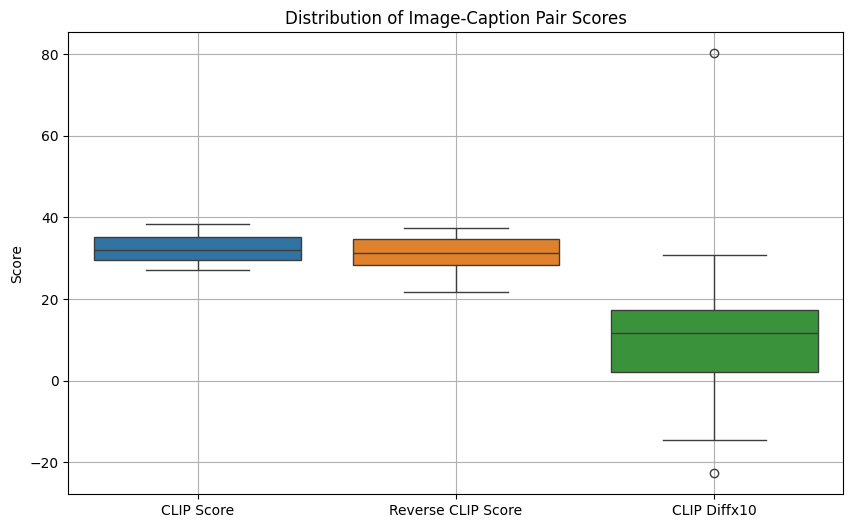

CLIP Score: Avrage:32.32964409722222 var: 11.093322141670887,  Reverse CLIP Score: avg:31.108262803819443 var:16.494511546176156,  CLIP Diff: avg:12.213812934027779 var: 431.17415941791774


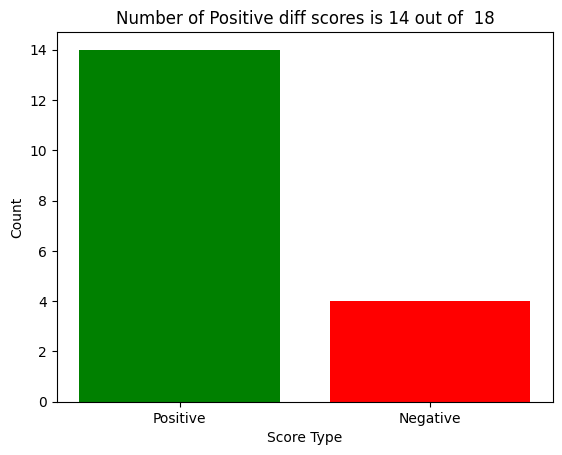

CSV file '/content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_2/clip_output.csv' created successfully.
Using cuda
Metric used is CLIP Score using cuda
Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_3/image_0_seed_44.png, Caption: A dog giving a present to a man., CLIP Score: 29.00390625, reverse caption A present givings a dog to a man., reverse score 28.0029296875, diff*10 10.009765625
Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_3/image_1_seed_44.png, Caption: A dolphin rescuing a swimmer., CLIP Score: 27.783203125, reverse caption A swimmer rescuings a dolphin., reverse score 26.2939453125, diff*10 14.892578125
Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_3/image_3_seed_44.png, Caption: A soldier delivering a message to a pigeon., CLIP Score: 37.79296875, reverse caption A message deliv

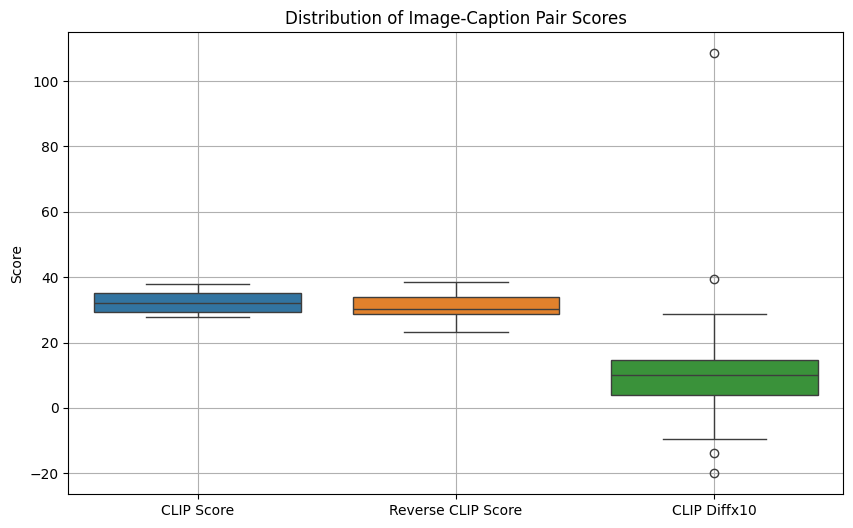

CLIP Score: Avrage:32.368977864583336 var: 11.052373382780287,  Reverse CLIP Score: avg:30.998399522569443 var:15.47454361930306,  CLIP Diff: avg:13.70578342013889 var: 723.6464248027331


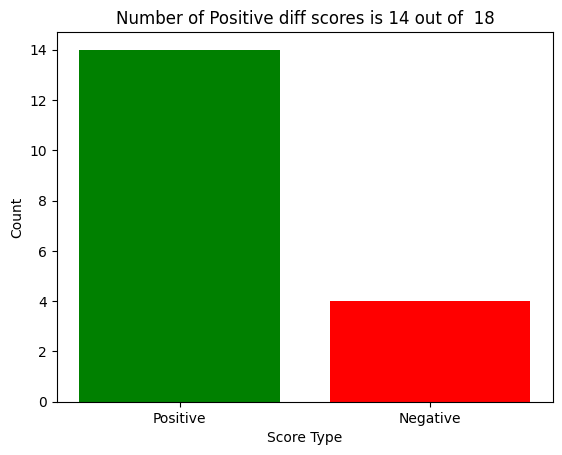

CSV file '/content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_3/clip_output.csv' created successfully.


In [38]:
#base benchmark evalauation
current_dir = f'/content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation'
save_dir = [None] * 4
json_file = [None] * 4
for i in range(4):
  save_dir[i] = f'{current_dir}/base_evaluation_{i}'
  json_file[i] = f'{save_dir[i]}/image_data.json'
  evaluation(save_dir[i],json_file[i],metric ='clip')

In [15]:
!pip install --upgrade transformers

  Using cached transformers-4.45.1-py3-none-any.whl.metadata (44 kB)
  Using cached tokenizers-0.20.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.7 kB)
Using cached transformers-4.45.1-py3-none-any.whl (9.9 MB)
Using cached tokenizers-0.20.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (2.9 MB)
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.15.2
    Uninstalling tokenizers-0.15.2:
      Successfully uninstalled tokenizers-0.15.2
  Attempting uninstall: transformers
    Found existing installation: transformers 4.36.2
    Uninstalling transformers-4.36.2:
      Successfully uninstalled transformers-4.36.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
spacy-transformers 1.3.5 requires transformers<4.37.0,>=3.4.0, but you have transformers 4.45.1 which is incompatible.


Using cuda
Metric used is BLIP Score


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Expanding inputs for image tokens in BLIP-2 should be done in processing. Please follow instruction here (https://gist.github.com/zucchini-nlp/e9f20b054fa322f84ac9311d9ab67042) to update your BLIP-2 model. Using processors without these attributes in the config is deprecated and will throw an error in v4.47.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic

Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_0/image_0_seed_41.png, Caption: A dog giving a present to a man., Generated Caption a man is giving a gift to his dog BLIP2 Score: 53.3636212348938, reverse caption: A present givings a dog to a man. , reverse BLIP score 40.75368940830231, diff*10 126.09931826591492


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transform

Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_0/image_1_seed_41.png, Caption: A dolphin rescuing a swimmer., Generated Caption a dolphin jumping out of the water BLIP2 Score: 60.64444184303284, reverse caption: A swimmer rescuings a dolphin. , reverse BLIP score 36.499711871147156, diff*10 241.4472997188568


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transform

Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_0/image_3_seed_41.png, Caption: A soldier delivering a message to a pigeon., Generated Caption a soldier feeding a pigeon on the street BLIP2 Score: 70.82108855247498, reverse caption: A message deliverings a soldier to a pigeon. , reverse BLIP score 44.10032331943512, diff*10 267.20765233039856


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transform

Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_0/image_4_seed_41.png, Caption: A rabbit bringing vegetables to a gardener., Generated Caption a man feeding a rabbit in a garden BLIP2 Score: 57.62162208557129, reverse caption: Vegetables bringings a rabbit to a gardener. , reverse BLIP score 40.7334178686142, diff*10 168.88204216957092


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transform

Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_0/image_5_seed_41.png, Caption: A squirrel helping a child find lost keys., Generated Caption a baby is playing with a squirrel BLIP2 Score: 50.88929533958435, reverse caption: Lost keys finds a child. , reverse BLIP score 37.40772902965546, diff*10 134.81566309928894


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transform

Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_0/image_6_seed_41.png, Caption: A cat bringing a toy to a baby., Generated Caption a baby is playing with a toy cat BLIP2 Score: 59.9073588848114, reverse caption: A toy bringings a cat to a baby. , reverse BLIP score 44.564270973205566, diff*10 153.43087911605835


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transform

Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_0/image_7_seed_41.png, Caption: A bird feeding an elderly person., Generated Caption an elderly woman feeding a bird BLIP2 Score: 73.34538102149963, reverse caption: An elderly person feedings a bird. , reverse BLIP score 82.45809078216553, diff*10 -91.12709760665894


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transform

Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_0/image_8_seed_41.png, Caption: A monkey handing tools to a mechanic., Generated Caption monkey mechanic - a monkey is working on a car BLIP2 Score: 55.72793483734131, reverse caption: Tools handings a monkey to a mechanic. , reverse BLIP score 41.329097747802734, diff*10 143.98837089538574


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transform

Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_0/image_9_seed_41.png, Caption: A rabbit helping a child with homework., Generated Caption a boy is sitting at a table with a rabbit BLIP2 Score: 43.50849390029907, reverse caption: A child helpings a rabbit with homework. , reverse BLIP score 43.493062257766724, diff*10 0.15431642532348633


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transform

Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_0/image_10_seed_41.png, Caption: A cat bringing a flower to a sick person, Generated Caption a woman is sitting on the grass with a cat BLIP2 Score: 40.45272469520569, reverse caption: A flower bringings a cat to a sick person. , reverse BLIP score 30.40788173675537, diff*10 100.44842958450317


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transform

Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_0/image_11_seed_41.png, Caption: A child giving homework to a teacher., Generated Caption a girl is writing with a pencil in front of a teacher BLIP2 Score: 51.988762617111206, reverse caption: Homework givings a child to a teacher. , reverse BLIP score 25.676676630973816, diff*10 263.1208598613739


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transform

Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_0/image_12_seed_41.png, Caption: A cat rescuing a fireman from a tree., Generated Caption a black cat is climbing a tree BLIP2 Score: 51.035118103027344, reverse caption: A fireman rescuings a cat from a tree. , reverse BLIP score 38.869041204452515, diff*10 121.66076898574829


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transform

Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_0/image_14_seed_41.png, Caption: A homeless person giving money to a billionaire., Generated Caption a homeless man handing a man a note BLIP2 Score: 59.96595025062561, reverse caption: Money givings a homeless person to a billionaire. , reverse BLIP score 31.695544719696045, diff*10 282.70405530929565


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transform

Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_0/image_15_seed_41.png, Caption: A student explains astrophysics to a teacher., Generated Caption a girl wearing a sweater BLIP2 Score: 38.45372200012207, reverse caption: Astrophysics explains a student to a teacher. , reverse BLIP score 25.132277607917786, diff*10 133.21444392204285


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transform

Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_0/image_16_seed_41.png, Caption: A child arresting a police officer., Generated Caption a young boy is being handed a handshake by a police officer BLIP2 Score: 58.654868602752686, reverse caption: A police officer arrestings a child. , reverse BLIP score 46.616390347480774, diff*10 120.38478255271912


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transform

Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_0/image_17_seed_41.png, Caption: A lawyer explaining to a farmer how to plant seeds., Generated Caption two men in suits kneeling down in the dirt BLIP2 Score: 30.460679531097412, reverse caption: Seeds plants a lawyer to a farmer how to. , reverse BLIP score 8.789954334497452, diff*10 216.7072519659996


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transform

Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_0/image_18_seed_41.png, Caption: A squirrel bringing nuts to a picnic., Generated Caption squirrel eating nuts on a picnic blanket BLIP2 Score: 55.72436451911926, reverse caption: Nuts bringings a squirrel to a picnic. , reverse BLIP score 31.21725618839264, diff*10 245.07108330726624


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transform

Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_0/image_19_seed_41.png, Caption: A cake eating a man., Generated Caption a man is cutting a cake BLIP2 Score: 48.04171621799469, reverse caption: A man eatings a cake. , reverse BLIP score 68.75784397125244, diff*10 -207.16127753257751


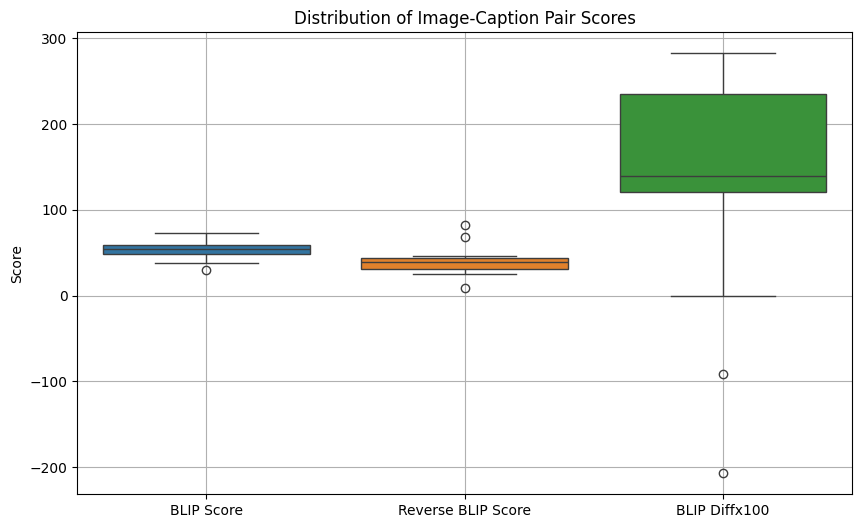

BLIP Score: Avrage:53.367063568698036 var: 108.50933200250924,  Reverse BLIP Score: avg:39.9167922221952 var:243.59489889215033,  BLIP Diff: avg:134.50271346502834 var: 15303.113286292497


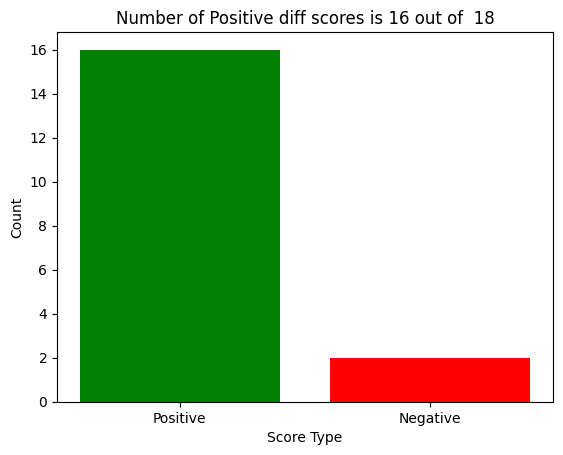

CSV file '/content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_0/blip_output.csv' created successfully.
Using cuda
Metric used is BLIP Score


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set.

Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_1/image_0_seed_42.png, Caption: A dog giving a present to a man., Generated Caption man and dog with gift boxes BLIP2 Score: 31.454089283943176, reverse caption: A present givings a dog to a man. , reverse BLIP score 13.968615233898163, diff*10 174.85474050045013


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transform

Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_1/image_1_seed_42.png, Caption: A dolphin rescuing a swimmer., Generated Caption two dolphins are jumping out of the water BLIP2 Score: 45.66013514995575, reverse caption: A swimmer rescuings a dolphin. , reverse BLIP score 29.90204691886902, diff*10 157.5808823108673


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transform

Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_1/image_3_seed_42.png, Caption: A soldier delivering a message to a pigeon., Generated Caption a man kneeling down next to a pigeon BLIP2 Score: 57.91630148887634, reverse caption: A message deliverings a soldier to a pigeon. , reverse BLIP score 36.003026366233826, diff*10 219.13275122642517


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transform

Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_1/image_4_seed_42.png, Caption: A rabbit bringing vegetables to a gardener., Generated Caption a man is feeding a rabbit in a garden BLIP2 Score: 52.27884650230408, reverse caption: Vegetables bringings a rabbit to a gardener. , reverse BLIP score 38.13110888004303, diff*10 141.47737622261047


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transform

Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_1/image_5_seed_42.png, Caption: A squirrel helping a child find lost keys., Generated Caption a squirrel is standing next to a little boy BLIP2 Score: 52.43903994560242, reverse caption: Lost keys finds a child. , reverse BLIP score 36.86184585094452, diff*10 155.77194094657898


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transform

Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_1/image_6_seed_42.png, Caption: A cat bringing a toy to a baby., Generated Caption a baby is playing with a toy cat BLIP2 Score: 59.9073588848114, reverse caption: A toy bringings a cat to a baby. , reverse BLIP score 44.564270973205566, diff*10 153.43087911605835


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transform

Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_1/image_7_seed_42.png, Caption: A bird feeding an elderly person., Generated Caption a woman feeding a bird BLIP2 Score: 69.03995275497437, reverse caption: An elderly person feedings a bird. , reverse BLIP score 73.25497269630432, diff*10 -42.15019941329956


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transform

Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_1/image_8_seed_42.png, Caption: A monkey handing tools to a mechanic., Generated Caption monkey mechanic in a garage BLIP2 Score: 52.87141799926758, reverse caption: Tools handings a monkey to a mechanic. , reverse BLIP score 36.47477924823761, diff*10 163.96638751029968


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transform

Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_1/image_9_seed_42.png, Caption: A rabbit helping a child with homework., Generated Caption a little girl is writing on a notebook BLIP2 Score: 43.423983454704285, reverse caption: A child helpings a rabbit with homework. , reverse BLIP score 41.436564922332764, diff*10 19.87418532371521


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transform

Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_1/image_10_seed_42.png, Caption: A cat bringing a flower to a sick person, Generated Caption a cat with blue eyes is smelling a flower BLIP2 Score: 39.9941086769104, reverse caption: A flower bringings a cat to a sick person. , reverse BLIP score 26.019102334976196, diff*10 139.75006341934204


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transform

Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_1/image_11_seed_42.png, Caption: A child giving homework to a teacher., Generated Caption a woman helping a boy with his homework BLIP2 Score: 57.60156512260437, reverse caption: Homework givings a child to a teacher. , reverse BLIP score 25.80547332763672, diff*10 317.9609179496765


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transform

Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_1/image_12_seed_42.png, Caption: A cat rescuing a fireman from a tree., Generated Caption a cat is climbing a tree with a man on a rope BLIP2 Score: 56.85533285140991, reverse caption: A fireman rescuings a cat from a tree. , reverse BLIP score 39.47852849960327, diff*10 173.7680435180664


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transform

Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_1/image_14_seed_42.png, Caption: A homeless person giving money to a billionaire., Generated Caption two homeless men handing out money to each other BLIP2 Score: 59.050554037094116, reverse caption: Money givings a homeless person to a billionaire. , reverse BLIP score 23.857326805591583, diff*10 351.93227231502533


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transform

Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_1/image_15_seed_42.png, Caption: A student explains astrophysics to a teacher., Generated Caption a man wearing a blue shirt BLIP2 Score: 24.241143465042114, reverse caption: Astrophysics explains a student to a teacher. , reverse BLIP score 13.815130293369293, diff*10 104.26013171672821


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transform

Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_1/image_16_seed_42.png, Caption: A child arresting a police officer., Generated Caption a police officer is holding a child in his arms BLIP2 Score: 52.85103917121887, reverse caption: A police officer arrestings a child. , reverse BLIP score 58.29312801361084, diff*10 -54.42088842391968


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transform

Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_1/image_17_seed_42.png, Caption: A lawyer explaining to a farmer how to plant seeds., Generated Caption two men in suits kneeling in a field BLIP2 Score: 27.704566717147827, reverse caption: Seeds plants a lawyer to a farmer how to. , reverse BLIP score 5.292803049087524, diff*10 224.11763668060303


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transform

Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_1/image_18_seed_42.png, Caption: A squirrel bringing nuts to a picnic., Generated Caption squirrel eating nuts on the ground BLIP2 Score: 42.595112323760986, reverse caption: Nuts bringings a squirrel to a picnic. , reverse BLIP score 21.108737587928772, diff*10 214.86374735832214


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transform

Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_1/image_19_seed_42.png, Caption: A cake eating a man., Generated Caption a cake with a man on top BLIP2 Score: 51.55196785926819, reverse caption: A man eatings a cake. , reverse BLIP score 46.30839824676514, diff*10 52.43569612503052


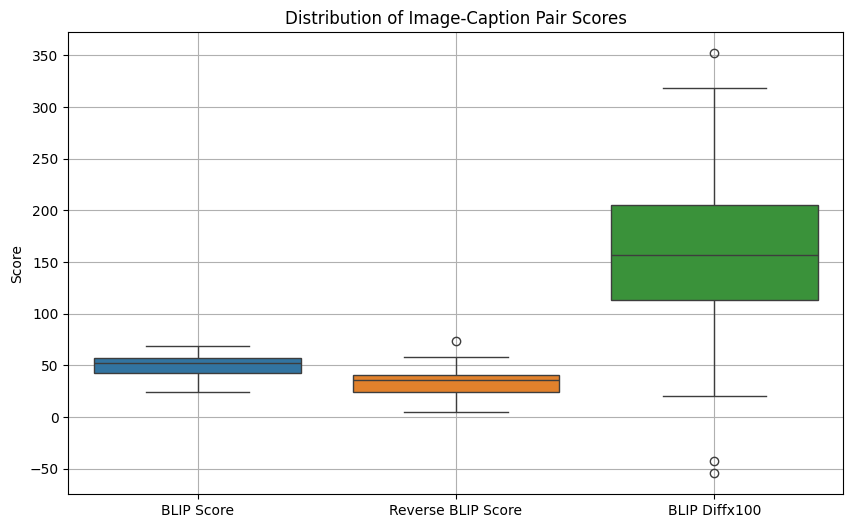

BLIP Score: Avrage:48.74647309382757 var: 135.18110970285593,  Reverse BLIP Score: avg:33.92088106936879 var:253.571754540554,  BLIP Diff: avg:148.2559202445878 var: 10684.67070307586


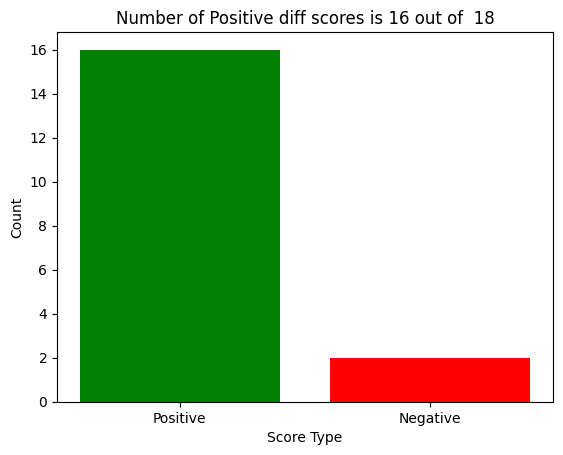

CSV file '/content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_1/blip_output.csv' created successfully.
Using cuda
Metric used is BLIP Score


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set.

Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_2/image_0_seed_43.png, Caption: A dog giving a present to a man., Generated Caption a man is standing next to a dog with a gift box BLIP2 Score: 47.10922837257385, reverse caption: A present givings a dog to a man. , reverse BLIP score 28.648710250854492, diff*10 184.6051812171936


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transform

Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_2/image_1_seed_43.png, Caption: A dolphin rescuing a swimmer., Generated Caption two dolphins swimming in the ocean BLIP2 Score: 57.14665651321411, reverse caption: A swimmer rescuings a dolphin. , reverse BLIP score 35.630545020103455, diff*10 215.16111493110657


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transform

Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_2/image_3_seed_43.png, Caption: A soldier delivering a message to a pigeon., Generated Caption a soldier is feeding a bird BLIP2 Score: 56.81273937225342, reverse caption: A message deliverings a soldier to a pigeon. , reverse BLIP score 42.311522364616394, diff*10 145.01217007637024


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transform

Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_2/image_4_seed_43.png, Caption: A rabbit bringing vegetables to a gardener., Generated Caption a painting of a man with a basket of vegetables and rabbits BLIP2 Score: 37.55919933319092, reverse caption: Vegetables bringings a rabbit to a gardener. , reverse BLIP score 19.71699744462967, diff*10 178.4220188856125


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transform

Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_2/image_5_seed_43.png, Caption: A squirrel helping a child find lost keys., Generated Caption a squirrel is holding a key to a lock BLIP2 Score: 50.80860257148743, reverse caption: Lost keys finds a child. , reverse BLIP score 33.53601396083832, diff*10 172.7258861064911


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transform

Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_2/image_6_seed_43.png, Caption: A cat bringing a toy to a baby., Generated Caption a baby and cat playing with toys BLIP2 Score: 57.87975192070007, reverse caption: A toy bringings a cat to a baby. , reverse BLIP score 35.02257764339447, diff*10 228.57174277305603


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transform

Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_2/image_7_seed_43.png, Caption: A bird feeding an elderly person., Generated Caption an elderly woman is feeding a bird BLIP2 Score: 62.098658084869385, reverse caption: An elderly person feedings a bird. , reverse BLIP score 72.06672430038452, diff*10 -99.68066215515137


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transform

Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_2/image_8_seed_43.png, Caption: A monkey handing tools to a mechanic., Generated Caption monkey is holding a wrench BLIP2 Score: 42.044779658317566, reverse caption: Tools handings a monkey to a mechanic. , reverse BLIP score 31.911221146583557, diff*10 101.33558511734009


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transform

Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_2/image_9_seed_43.png, Caption: A rabbit helping a child with homework., Generated Caption a girl is writing with a rabbit on a desk BLIP2 Score: 41.40382707118988, reverse caption: A child helpings a rabbit with homework. , reverse BLIP score 41.549116373062134, diff*10 -1.4528930187225342


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transform

Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_2/image_10_seed_43.png, Caption: A cat bringing a flower to a sick person, Generated Caption a cat is playing with a pink ball in the grass BLIP2 Score: 44.48544681072235, reverse caption: A flower bringings a cat to a sick person. , reverse BLIP score 27.667272090911865, diff*10 168.18174719810486


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transform

Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_2/image_11_seed_43.png, Caption: A child giving homework to a teacher., Generated Caption a woman and a boy are working on homework BLIP2 Score: 51.196616888046265, reverse caption: Homework givings a child to a teacher. , reverse BLIP score 23.31903725862503, diff*10 278.77579629421234


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transform

Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_2/image_12_seed_43.png, Caption: A cat rescuing a fireman from a tree., Generated Caption a firefighter is climbing a tree with a sign BLIP2 Score: 50.24297833442688, reverse caption: A fireman rescuings a cat from a tree. , reverse BLIP score 44.790226221084595, diff*10 54.52752113342285


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transform

Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_2/image_14_seed_43.png, Caption: A homeless person giving money to a billionaire., Generated Caption a man is sitting on the sidewalk with a paper BLIP2 Score: 39.121800661087036, reverse caption: Money givings a homeless person to a billionaire. , reverse BLIP score 19.053511321544647, diff*10 200.6828933954239


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transform

Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_2/image_15_seed_43.png, Caption: A student explains astrophysics to a teacher., Generated Caption a boy wearing a blue shirt BLIP2 Score: 31.657439470291138, reverse caption: Astrophysics explains a student to a teacher. , reverse BLIP score 18.978995084762573, diff*10 126.78444385528564


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transform

Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_2/image_16_seed_43.png, Caption: A child arresting a police officer., Generated Caption a young boy is standing next to a police officer BLIP2 Score: 64.40699696540833, reverse caption: A police officer arrestings a child. , reverse BLIP score 48.77693057060242, diff*10 156.30066394805908


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transform

Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_2/image_17_seed_43.png, Caption: A lawyer explaining to a farmer how to plant seeds., Generated Caption two businessmen in suits are looking at plants in a field BLIP2 Score: 37.901341915130615, reverse caption: Seeds plants a lawyer to a farmer how to. , reverse BLIP score 16.414296627044678, diff*10 214.87045288085938


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transform

Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_2/image_18_seed_43.png, Caption: A squirrel bringing nuts to a picnic., Generated Caption squirrel with nuts in basket BLIP2 Score: 39.71059024333954, reverse caption: Nuts bringings a squirrel to a picnic. , reverse BLIP score 14.406853914260864, diff*10 253.03736329078674


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transform

Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_2/image_19_seed_43.png, Caption: A cake eating a man., Generated Caption a man eating a cake BLIP2 Score: 62.88391351699829, reverse caption: A man eatings a cake. , reverse BLIP score 83.67904424667358, diff*10 -207.95130729675293


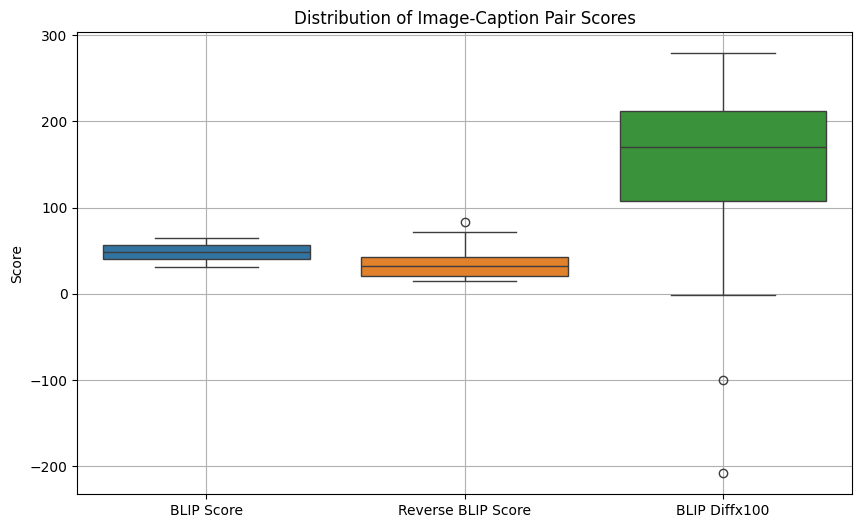

BLIP Score: Avrage:48.58169820573595 var: 93.51130997344973,  Reverse BLIP Score: avg:35.41553310222096 var:326.6199382840514,  BLIP Diff: avg:131.6616510351499 var: 14816.094130158282


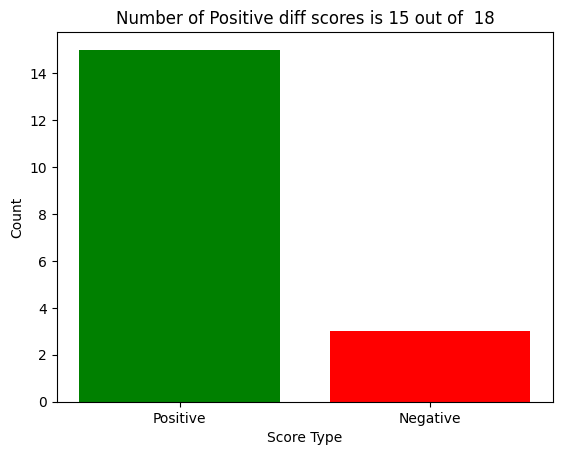

CSV file '/content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_2/blip_output.csv' created successfully.
Using cuda
Metric used is BLIP Score


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set.

Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_3/image_0_seed_44.png, Caption: A dog giving a present to a man., Generated Caption a man is petting a dog in the park BLIP2 Score: 47.43050038814545, reverse caption: A present givings a dog to a man. , reverse BLIP score 29.52268123626709, diff*10 179.07819151878357


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transform

Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_3/image_1_seed_44.png, Caption: A dolphin rescuing a swimmer., Generated Caption three dolphins jumping out of the water BLIP2 Score: 59.5724880695343, reverse caption: A swimmer rescuings a dolphin. , reverse BLIP score 35.76658368110657, diff*10 238.05904388427734


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transform

Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_3/image_3_seed_44.png, Caption: A soldier delivering a message to a pigeon., Generated Caption a soldier is feeding a pigeon in front of a building BLIP2 Score: 61.97875738143921, reverse caption: A message deliverings a soldier to a pigeon. , reverse BLIP score 36.834970116615295, diff*10 251.43787264823914


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transform

Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_3/image_4_seed_44.png, Caption: A rabbit bringing vegetables to a gardener., Generated Caption a man is weeding a garden with a rabbit BLIP2 Score: 47.719138860702515, reverse caption: Vegetables bringings a rabbit to a gardener. , reverse BLIP score 30.607134103775024, diff*10 171.1200475692749


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transform

Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_3/image_5_seed_44.png, Caption: A squirrel helping a child find lost keys., Generated Caption a squirrel is playing with a child BLIP2 Score: 60.4364275932312, reverse caption: Lost keys finds a child. , reverse BLIP score 39.21076059341431, diff*10 212.25666999816895


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transform

Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_3/image_6_seed_44.png, Caption: A cat bringing a toy to a baby., Generated Caption a cat and kitten sitting on a wooden floor BLIP2 Score: 48.10140132904053, reverse caption: A toy bringings a cat to a baby. , reverse BLIP score 26.826536655426025, diff*10 212.74864673614502


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transform

Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_3/image_7_seed_44.png, Caption: A bird feeding an elderly person., Generated Caption an elderly woman feeding a bird BLIP2 Score: 73.34538102149963, reverse caption: An elderly person feedings a bird. , reverse BLIP score 82.45809078216553, diff*10 -91.12709760665894


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transform

Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_3/image_8_seed_44.png, Caption: A monkey handing tools to a mechanic., Generated Caption two men are holding a monkey BLIP2 Score: 49.4105726480484, reverse caption: Tools handings a monkey to a mechanic. , reverse BLIP score 42.80407726764679, diff*10 66.06495380401611


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transform

Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_3/image_9_seed_44.png, Caption: A rabbit helping a child with homework., Generated Caption a girl writing with a rabbit at a table BLIP2 Score: 47.29410707950592, reverse caption: A child helpings a rabbit with homework. , reverse BLIP score 43.93744468688965, diff*10 33.56662392616272


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transform

Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_3/image_10_seed_44.png, Caption: A cat bringing a flower to a sick person, Generated Caption a cat reaching for a flower BLIP2 Score: 64.11948800086975, reverse caption: A flower bringings a cat to a sick person. , reverse BLIP score 39.665067195892334, diff*10 244.54420804977417


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transform

Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_3/image_11_seed_44.png, Caption: A child giving homework to a teacher., Generated Caption a woman and a boy are working on homework BLIP2 Score: 51.196616888046265, reverse caption: Homework givings a child to a teacher. , reverse BLIP score 23.31903725862503, diff*10 278.77579629421234


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transform

Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_3/image_12_seed_44.png, Caption: A cat rescuing a fireman from a tree., Generated Caption a man climbing a tree with a rope BLIP2 Score: 49.779096245765686, reverse caption: A fireman rescuings a cat from a tree. , reverse BLIP score 43.421581387519836, diff*10 63.575148582458496


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transform

Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_3/image_14_seed_44.png, Caption: A homeless person giving money to a billionaire., Generated Caption a homeless man is giving a homeless man a piece of paper BLIP2 Score: 51.99391841888428, reverse caption: Money givings a homeless person to a billionaire. , reverse BLIP score 33.71478319168091, diff*10 182.7913522720337


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transform

Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_3/image_15_seed_44.png, Caption: A student explains astrophysics to a teacher., Generated Caption a man is holding a paper BLIP2 Score: 26.73044204711914, reverse caption: Astrophysics explains a student to a teacher. , reverse BLIP score 16.817855834960938, diff*10 99.12586212158203


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transform

Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_3/image_16_seed_44.png, Caption: A child arresting a police officer., Generated Caption a police officer is helping a young boy BLIP2 Score: 49.269306659698486, reverse caption: A police officer arrestings a child. , reverse BLIP score 56.11083507537842, diff*10 -68.41528415679932


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transform

Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_3/image_17_seed_44.png, Caption: A lawyer explaining to a farmer how to plant seeds., Generated Caption two men in suits kneeling in a field with a tablet BLIP2 Score: 28.605660796165466, reverse caption: Seeds plants a lawyer to a farmer how to. , reverse BLIP score 7.1203455328941345, diff*10 214.85315263271332


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transform

Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_3/image_18_seed_44.png, Caption: A squirrel bringing nuts to a picnic., Generated Caption squirrels, squirrels in a basket, squirrels, squirrels in a basket BLIP2 Score: 15.839456021785736, reverse caption: Nuts bringings a squirrel to a picnic. , reverse BLIP score 11.809489130973816, diff*10 40.2996689081192


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transform

Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_3/image_19_seed_44.png, Caption: A cake eating a man., Generated Caption a man is cutting a cake BLIP2 Score: 48.04171621799469, reverse caption: A man eatings a cake. , reverse BLIP score 68.75784397125244, diff*10 -207.16127753257751


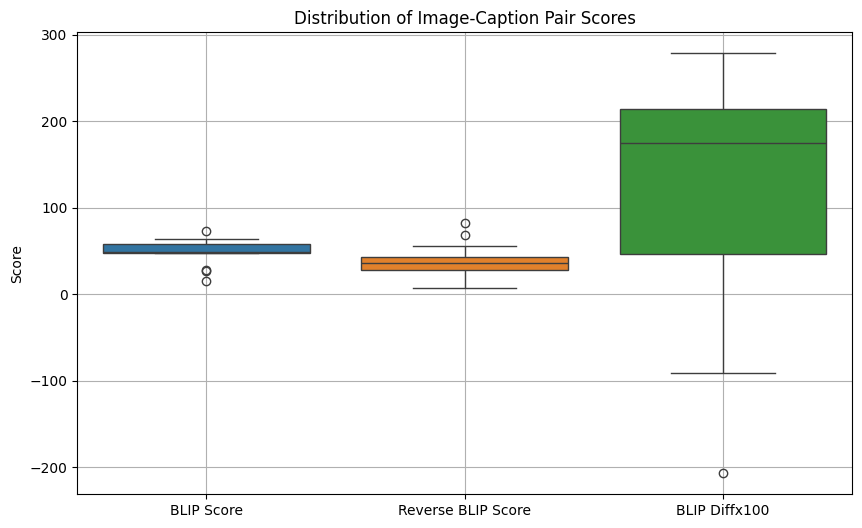

BLIP Score: Avrage:48.93691531485982 var: 181.50571644215267,  Reverse BLIP Score: avg:37.15028431680467 var:328.2956231638779,  BLIP Diff: avg:117.8663099805514 var: 17526.150849477835


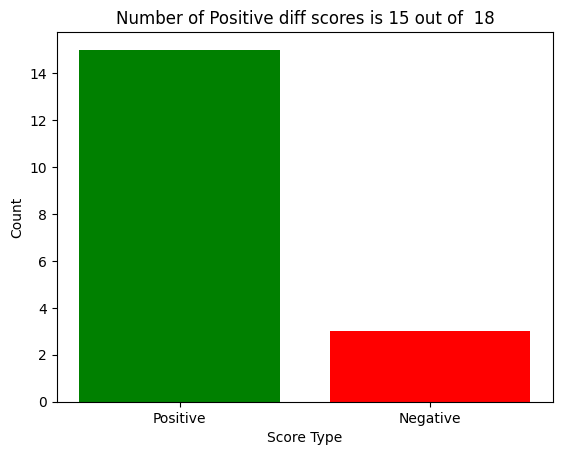

CSV file '/content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_3/blip_output.csv' created successfully.


In [16]:
  #base benchmark evalauation (Using BLIP BARST)
current_dir = f'/content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation'
save_dir = [None] * 4
json_file = [None] * 4
for i in range(len(save_dir)):
    save_dir[i] = f'{current_dir}/base_evaluation_{i}'
    json_file[i] = f'{save_dir[i]}/image_data.json'
    evaluation(save_dir[i],json_file[i],metric ='blip', output_file_name = "blip_output")

#Evaluation the base model usign winoground captions


This code use the original base model to generate images captions we considered as "interasting" from winoground
It saved in json file the image name, caption and reverse caption (generated fro caption using the function we used in the dataset filtering)

In [25]:
current_dir = f'/content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation'
winoground_captions_csv_file = f"{current_dir}/winoground_filtering_output.csv"
base_model_id  = "stabilityai/stable-diffusion-2-1-base"
captions_txt_none = "none"
seed_base =42
base_winoground_dir = f'{current_dir}/base_evaluation_winoground'
base_winoground_json_file = evaluate_model(base_model_id, captions_txt_none, base_winoground_dir, winoground_captions_csv_file, seed = seed_base)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/543 [00:00<?, ?B/s]

Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

scheduler/scheduler_config.json:   0%|          | 0.00/346 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.36G [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/807 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/613 [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/911 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.46G [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/553 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  


Evaluating using cuda


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

In [ ]:
torch.cuda.empty_cache()

Using cuda
Metric used is CLIP Score using cuda
Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_winoground/image_0_seed_42.png, Caption: an old person kisses a young person, CLIP Score: 29.19921875, reverse caption a young person kisses an old person, reverse score 30.517578125, diff*10 -13.18359375
Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_winoground/image_1_seed_42.png, Caption: the taller person hugs the shorter person, CLIP Score: 29.345703125, reverse caption the shorter person hugs the taller person, reverse score 29.4677734375, diff*10 -1.220703125
Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_winoground/image_2_seed_42.png, Caption: the masked wrestler hits the unmasked wrestler, CLIP Score: 31.15234375, reverse caption the unmasked wrestler hits the masked wrestler, reverse score 30.6640625, diff*10 4.8828125
Image: /c

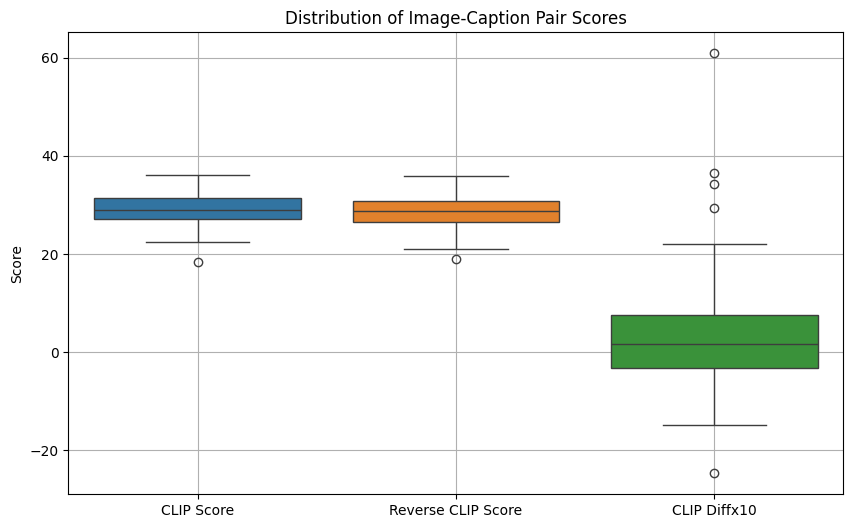

CLIP Score: Avrage:29.184517809139784 var: 10.225197830314869,  Reverse CLIP Score: avg:28.826576150873656 var:10.34153915027729,  CLIP Diff: avg:3.5794165826612905 var: 130.2672846632371


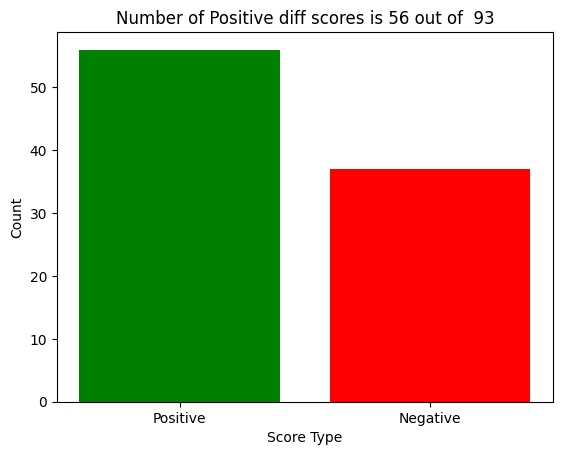

CSV file '/content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_winoground/clip_output.csv' created successfully.


In [42]:
#base winoground evalauation
current_dir = f'/content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation'
base_winoground_dir = f'{current_dir}/base_evaluation_winoground'
base_winoground_json_file = f'{base_winoground_dir}/image_data.json'
evaluation(base_winoground_dir,base_winoground_json_file,metric ='clip')

Using cuda
Metric used is BLIP Score


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set.

Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_winoground/image_0_seed_42.png, Caption: an old person kisses a young person, Generated Caption two older women kissing BLIP2 Score: 38.28318119049072, reverse caption: a young person kisses an old person , reverse BLIP score 37.503787875175476, diff*10 7.793933153152466


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transform

Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_winoground/image_1_seed_42.png, Caption: the taller person hugs the shorter person, Generated Caption two people hugging in the woods BLIP2 Score: 31.52260184288025, reverse caption: the shorter person hugs the taller person , reverse BLIP score 30.82047998905182, diff*10 7.021218538284302


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transform

Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_winoground/image_2_seed_42.png, Caption: the masked wrestler hits the unmasked wrestler, Generated Caption two wrestlers in a wrestling ring BLIP2 Score: 27.284163236618042, reverse caption: the unmasked wrestler hits the masked wrestler , reverse BLIP score 25.73053240776062, diff*10 15.536308288574219


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transform

Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_winoground/image_3_seed_42.png, Caption: a person watches an animal, Generated Caption a giraffe standing next to a tree BLIP2 Score: 27.879628539085388, reverse caption: an animal watches a person , reverse BLIP score 26.464226841926575, diff*10 14.154016971588135


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transform

Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_winoground/image_4_seed_42.png, Caption: the person without earrings pays the person with earrings, Generated Caption a young woman wearing hoop earrings BLIP2 Score: 32.28228688240051, reverse caption: the person with earrings pays the person without earrings , reverse BLIP score 29.39578890800476, diff*10 28.86497974395752


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transform

Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_winoground/image_5_seed_42.png, Caption: a bird eats a snake, Generated Caption a bird with a snake in its mouth BLIP2 Score: 62.46404051780701, reverse caption: a snake eats a bird , reverse BLIP score 52.58267521858215, diff*10 98.81365299224854


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transform

Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_winoground/image_6_seed_42.png, Caption: a plant was harmed by another organism, and that organism broke the plant into pieces, Generated Caption a plant growing in a dry field BLIP2 Score: 21.81905210018158, reverse caption: another organism was harmed by a plant, and that plant broke the organism into pieces , reverse BLIP score 22.752918303012848, diff*10 -9.338662028312683


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transform

Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_winoground/image_7_seed_42.png, Caption: the image shows a computer on top of books, Generated Caption a laptop computer on a desk with a folder on top BLIP2 Score: 45.71826457977295, reverse caption: the image shows books on top of a computer , reverse BLIP score 45.70039510726929, diff*10 0.1786947250366211


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transform

Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_winoground/image_8_seed_42.png, Caption: the person with the white collared shirt waters the plant while the other holds it, Generated Caption a man is planting marijuana in a field BLIP2 Score: 16.37117564678192, reverse caption: the person with the white collared shirt holds the plant while the other waters it , reverse BLIP score 18.009105324745178, diff*10 -16.37929677963257


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transform

Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_winoground/image_9_seed_42.png, Caption: the taller person chops food and the shorter person eats food, Generated Caption a comic showing a man eating carrots BLIP2 Score: 18.072816729545593, reverse caption: the taller person eats food and the shorter person chops food , reverse BLIP score 17.759667336940765, diff*10 3.131493926048279


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transform

Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_winoground/image_10_seed_42.png, Caption: the person with the ponytail packs stuff and other buys it, Generated Caption woman pointing at shelves in a store BLIP2 Score: 5.6960079818964005, reverse caption: the person with the ponytail buys stuff and other packs it , reverse BLIP score 3.7430576980113983, diff*10 19.52950283885002


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transform

Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_winoground/image_11_seed_42.png, Caption: the square table has a round base, Generated Caption a small wooden table in front of a plant BLIP2 Score: 34.1827929019928, reverse caption: the round table has a square base , reverse BLIP score 32.56195783615112, diff*10 16.208350658416748


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transform

Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_winoground/image_12_seed_42.png, Caption: the more content person has the healthier food and the less content person has the less healthy food, Generated Caption a poster showing different types of food BLIP2 Score: 3.7754427641630173, reverse caption: the less content person has the healthier food and the more content person has the less healthy food , reverse BLIP score 1.8642714247107506, diff*10 19.111713394522667


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transform

Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_winoground/image_13_seed_42.png, Caption: the larger person wears yellow and the smaller person does not, Generated Caption a man and woman standing in front of a yellow street sign BLIP2 Score: 12.358302623033524, reverse caption: the smaller person wears yellow and the larger person does not , reverse BLIP score 11.668330430984497, diff*10 6.899721920490265


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transform

Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_winoground/image_14_seed_42.png, Caption: it wears a hat but the person doesn't, Generated Caption a cartoon of a man in a hat BLIP2 Score: 24.84957128763199, reverse caption: the person wears a hat but it doesn't , reverse BLIP score 23.666690289974213, diff*10 11.828809976577759


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transform

Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_winoground/image_15_seed_42.png, Caption: someone bakes the dough before the dough is eaten, Generated Caption a person is kneading dough on a baking sheet BLIP2 Score: 32.42058753967285, reverse caption: the dough is eaten before someone bakes the dough , reverse BLIP score 40.10023474693298, diff*10 -76.79647207260132


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transform

Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_winoground/image_16_seed_42.png, Caption: someone has loaded their plate with one of the toast slices and two of the eggs, Generated Caption two fried eggs on a plate with basil BLIP2 Score: 13.991853594779968, reverse caption: someone has loaded their plate with two of the toast slices and one of the eggs , reverse BLIP score 13.08327317237854, diff*10 9.085804224014282


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transform

Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_winoground/image_17_seed_42.png, Caption: no people wear blue shirts and six people wear white shirts, Generated Caption a group of people in blue shirts and ties BLIP2 Score: 34.517839550971985, reverse caption: six people wear blue shirts and no people wear white shirts , reverse BLIP score 29.263001680374146, diff*10 52.548378705978394


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transform

Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_winoground/image_18_seed_42.png, Caption: the person with the lighter shoes is holding an emoji and the person with the darker shoes isn't, Generated Caption two people with their feet on the ground holding a smiley face and a sign BLIP2 Score: 12.43264302611351, reverse caption: the person with the darker shoes is holding an emoji and the person with the lighter shoes isn't , reverse BLIP score 12.12906539440155, diff*10 3.0357763171195984


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transform

Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_winoground/image_19_seed_42.png, Caption: the person wearing neutral colors poses and the person wearing brighter colors takes a picture, Generated Caption two women standing on the street with their bags BLIP2 Score: 21.45928591489792, reverse caption: the person wearing brighter colors poses and the person wearing neutral colors takes a picture , reverse BLIP score 19.371674954891205, diff*10 20.87610960006714


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transform

Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_winoground/image_20_seed_42.png, Caption: the people with shoes are touching each other, Generated Caption multiracial people holding hands in a circle BLIP2 Score: 12.745368480682373, reverse caption: the people are touching each other with shoes , reverse BLIP score 13.189010322093964, diff*10 -4.436418414115906


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transform

Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_winoground/image_21_seed_42.png, Caption: the person that is on the table is eating the food, Generated Caption a group of people eating food on a table BLIP2 Score: 44.40792798995972, reverse caption: the person is eating the food that is on the table , reverse BLIP score 50.504279136657715, diff*10 -60.96351146697998


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transform

Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_winoground/image_22_seed_42.png, Caption: they hold a suitcase handle with their left hand and they hold a passport with their right hand, Generated Caption a man holding a passport and a phone BLIP2 Score: 30.279046297073364, reverse caption: they hold a passport with their left hand and they hold a suitcase handle with their right hand , reverse BLIP score 30.973929166793823, diff*10 -6.94882869720459


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transform

Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_winoground/image_23_seed_42.png, Caption: the person who is wearing a crown is kissing a frog, Generated Caption a girl with a crown and a frog on her lips BLIP2 Score: 42.22503304481506, reverse caption: the person is kissing a frog who is wearing a crown , reverse BLIP score 41.656866669654846, diff*10 5.681663751602173


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transform

Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_winoground/image_24_seed_42.png, Caption: The uncaged bird has an opened cage door, Generated Caption a bird in a cage BLIP2 Score: 47.64719903469086, reverse caption: The caged bird has an unopened cage door , reverse BLIP score 46.303170919418335, diff*10 13.44028115272522


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transform

Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_winoground/image_25_seed_42.png, Caption: they are using no bait but still got fish, Generated Caption four fish swimming in a river BLIP2 Score: 17.698746919631958, reverse caption: they are using bait but still got no fish , reverse BLIP score 17.876635491847992, diff*10 -1.7788857221603394


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transform

Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_winoground/image_26_seed_42.png, Caption: someone on the ground is spraying water towards a vehicle, Generated Caption a white van with a fire hose BLIP2 Score: 31.650835275650024, reverse caption: someone is on a vehicle spraying water towards the ground , reverse BLIP score 34.25176739692688, diff*10 -26.009321212768555


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transform

Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_winoground/image_27_seed_42.png, Caption: the dog wears as a hat what someone would normally bite, Generated Caption a dog wearing a white hat on its head BLIP2 Score: 32.90056884288788, reverse caption: the dog bites what someone would normally wear as a hat , reverse BLIP score 32.83855319023132, diff*10 0.6201565265655518


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transform

Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_winoground/image_28_seed_42.png, Caption: someone is wearing a black hat and yellow shirt, Generated Caption man in yellow hat sitting on wooden bench BLIP2 Score: 33.09049904346466, reverse caption: someone is wearing a yellow hat and black shirt , reverse BLIP score 33.46043527126312, diff*10 -3.699362277984619


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transform

Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_winoground/image_29_seed_42.png, Caption: the red team kicking the ball directly next to the blue team, Generated Caption a group of boys playing soccer on a field BLIP2 Score: 24.73129630088806, reverse caption: the blue team kicking the ball directly next to the red team , reverse BLIP score 24.787519872188568, diff*10 -0.5622357130050659


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transform

Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_winoground/image_30_seed_42.png, Caption: person in white is reading the orange book, Generated Caption a man is reading a book BLIP2 Score: 38.28402757644653, reverse caption: person in orange is reading the white book , reverse BLIP score 38.49020302295685, diff*10 -2.0617544651031494


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transform

Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_winoground/image_31_seed_42.png, Caption: the balloon in the middle has less air and the other balloons have more air, Generated Caption a hot air balloon flying over a road BLIP2 Score: 5.474540218710899, reverse caption: the balloon in the middle has more air and the other balloons have less air , reverse BLIP score 6.444534659385681, diff*10 -9.699944406747818


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transform

Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_winoground/image_32_seed_42.png, Caption: the pool has no people and the area around it has a lot of people, Generated Caption a group of people in a pool BLIP2 Score: 30.08773922920227, reverse caption: the pool has a lot of people and the area around it has no people , reverse BLIP score 31.212279200553894, diff*10 -11.245399713516235


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transform

Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_winoground/image_33_seed_42.png, Caption: they're enjoying hot water on a cold day, Generated Caption two dogs are playing in a tub with steam coming out of it BLIP2 Score: 27.116236090660095, reverse caption: they're enjoying cold water on a hot day , reverse BLIP score 27.641457319259644, diff*10 -5.252212285995483


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transform

Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_winoground/image_34_seed_42.png, Caption: the person on the left has curly hair and the person on the right has straight hair, Generated Caption two pictures of a man and a woman with curly hair BLIP2 Score: 33.11808109283447, reverse caption: the person on the left has straight hair and the person on the right has curly hair , reverse BLIP score 32.419103384017944, diff*10 6.989777088165283


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transform

Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_winoground/image_35_seed_42.png, Caption: a dog is using a wheelchair next to a person, Generated Caption a dog in a wheelchair with a person BLIP2 Score: 70.39902210235596, reverse caption: a person is using a wheelchair next to a dog , reverse BLIP score 59.20435190200806, diff*10 111.946702003479


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transform

Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_winoground/image_36_seed_42.png, Caption: a more lightly-colored dog is holding a toy next to a black dog, Generated Caption two dogs with stuffed animals sitting next to each other BLIP2 Score: 28.467750549316406, reverse caption: a black dog is holding a toy next to a more lightly-colored dog , reverse BLIP score 31.056851148605347, diff*10 -25.891005992889404


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transform

Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_winoground/image_37_seed_42.png, Caption: a person is casting a shadow beside a ball, Generated Caption a person walking across a desert BLIP2 Score: 33.19973349571228, reverse caption: a ball is casting a shadow beside a person , reverse BLIP score 28.460615873336792, diff*10 47.39117622375488


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transform

Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_winoground/image_38_seed_42.png, Caption: the child is throwing the adult the ball, Generated Caption mother and child playing with pink balls in the yard BLIP2 Score: 25.44260025024414, reverse caption: the adult is throwing the child the ball , reverse BLIP score 34.71829295158386, diff*10 -92.75692701339722


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transform

Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_winoground/image_39_seed_42.png, Caption: the person reached the base before the ball, Generated Caption a man is kicking a soccer ball in the dirt BLIP2 Score: 33.524006605148315, reverse caption: the ball reached the base before the person , reverse BLIP score 31.44896626472473, diff*10 20.75040340423584


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transform

Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_winoground/image_40_seed_42.png, Caption: an adult kisses a child, Generated Caption a woman is kissing a boy BLIP2 Score: 54.174619913101196, reverse caption: a child kisses an adult , reverse BLIP score 55.23431897163391, diff*10 -10.596990585327148


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transform

Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_winoground/image_41_seed_42.png, Caption: the person on the left has their arms up and the person on the right has their arms down, Generated Caption three young women raising their hands in class BLIP2 Score: 7.954655587673187, reverse caption: the person on the right has their arms up and the person on the left has their arms down , reverse BLIP score 8.438734710216522, diff*10 -4.84079122543335


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transform

Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_winoground/image_42_seed_42.png, Caption: the person on the left is holding the phone and the person on the right is staring at it, Generated Caption two people are looking at their phones BLIP2 Score: 25.889068841934204, reverse caption: the person on the right is holding the phone and the person on the left is staring at it , reverse BLIP score 26.071828603744507, diff*10 -1.8275976181030273


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transform

Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_winoground/image_43_seed_42.png, Caption: the person on the left is blowing bubbles and the person on the right is watching, Generated Caption a drawing of a woman with a hat and a bucket BLIP2 Score: 21.91917449235916, reverse caption: the person on the right is blowing bubbles and the person on the left is watching , reverse BLIP score 22.076261043548584, diff*10 -1.570865511894226


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transform

Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_winoground/image_44_seed_42.png, Caption: they worked out then they drank water, Generated Caption a boy is standing in the water next to a group of sheep BLIP2 Score: 14.680519700050354, reverse caption: they drank water then they worked out , reverse BLIP score 18.063774704933167, diff*10 -33.832550048828125


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transform

Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_winoground/image_45_seed_42.png, Caption: The kid throws the pancake and the adult sees it, Generated Caption a man and a boy are fighting in a room BLIP2 Score: 30.89277148246765, reverse caption: The kids see the pancake and the adult throws it , reverse BLIP score 24.679841101169586, diff*10 62.12930381298065


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transform

Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_winoground/image_46_seed_42.png, Caption: an older person blocking a younger person, Generated Caption an elderly woman is hugging an elderly man BLIP2 Score: 50.98896026611328, reverse caption: a younger person blocking an older person , reverse BLIP score 50.76215863227844, diff*10 2.2680163383483887


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transform

Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_winoground/image_47_seed_42.png, Caption: a person cries while another person wearing jewelry above their shoulders consoles, Generated Caption two women are laughing and smiling while sharing a kiss BLIP2 Score: 15.458887815475464, reverse caption: a person consoles while another person wearing jewelry above their shoulders cries , reverse BLIP score 16.202576458454132, diff*10 -7.436886429786682


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transform

Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_winoground/image_48_seed_42.png, Caption: a person with long hair eating a meat-based product while a person with short hair snacks on some fries, Generated Caption a couple eating french fries and chicken BLIP2 Score: 31.51373565196991, reverse caption: a person with short hair eating a meat-based product while a person with long hair snacks on some fries , reverse BLIP score 31.49413764476776, diff*10 0.19598007202148438


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transform

Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_winoground/image_49_seed_42.png, Caption: You can catch more flies with honey than you can with vinegar, Generated Caption honey bee in jar on wooden background BLIP2 Score: -6.26315101981163, reverse caption: You can catch more flies with vinegar than you can with honey , reverse BLIP score -5.680574849247932, diff*10 -5.825761705636978


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transform

Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_winoground/image_50_seed_42.png, Caption: I need my strength back, Generated Caption i need my strength bacc ack BLIP2 Score: 43.184080719947815, reverse caption: I need my back strength , reverse BLIP score 50.03852844238281, diff*10 -68.54447722434998


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transform

Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_winoground/image_51_seed_42.png, Caption: the driver wearing a shirt is in front of the other person wearing a sleeveless top, Generated Caption two people standing next to a police tape BLIP2 Score: 21.727795898914337, reverse caption: the driver wearing a sleeveless top is in front of the other person wearing a shirt , reverse BLIP score 21.741144359111786, diff*10 -0.1334846019744873


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transform

Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_winoground/image_52_seed_42.png, Caption: the person with hair to their shoulders has brown eyes and the other person's are blue, Generated Caption a young boy with curly hair and orange eyes BLIP2 Score: 25.831925868988037, reverse caption: the person with hair to their shoulders has blue eyes and the other person's are brown , reverse BLIP score 24.122516810894012, diff*10 17.094090580940247


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transform

Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_winoground/image_53_seed_42.png, Caption: a human being on a device that intercepts the sun's rays, Generated Caption a person is sitting on a roof BLIP2 Score: 32.126012444496155, reverse caption: a device that intercepts the sun's rays on a human being , reverse BLIP score 29.204270243644714, diff*10 29.217422008514404


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transform

Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_winoground/image_54_seed_42.png, Caption: two people; the one on the right has curly hair and the one on the left doesn't, Generated Caption two women with curly hair are smiling BLIP2 Score: 24.235880374908447, reverse caption: two people; the one on the left has curly hair and the one on the right doesn't , reverse BLIP score 24.371671676635742, diff*10 -1.3579130172729492


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transform

Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_winoground/image_55_seed_42.png, Caption: using the laptop while the guitar is close by, Generated Caption a young man playing an acoustic guitar in a room BLIP2 Score: 25.760304927825928, reverse caption: using the guitar while the laptop is close by , reverse BLIP score 28.416860103607178, diff*10 -26.5655517578125


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transform

Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_winoground/image_56_seed_42.png, Caption: the younger person is making noise while the other is silent, Generated Caption two women sitting on a bench talking BLIP2 Score: 18.552199006080627, reverse caption: the younger person is silent while the other is making noise , reverse BLIP score 18.83402168750763, diff*10 -2.8182268142700195


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transform

Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_winoground/image_57_seed_42.png, Caption: the gesture of the person sitting down is supporting the understanding of the person standing up, Generated Caption a man sitting on a chair with his arms out BLIP2 Score: 20.3239768743515, reverse caption: the gesture of the person standing up is supporting the understanding of the person sitting down , reverse BLIP score 19.103625416755676, diff*10 12.203514575958252


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transform

Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_winoground/image_58_seed_42.png, Caption: the outlet carrying water from the faucet to the shower head is near the hot tap not the cold, Generated Caption a bathtub with a faucet and a shower head BLIP2 Score: 35.05270183086395, reverse caption: the outlet carrying water from the faucet to the shower head is near the cold tap not the hot , reverse BLIP score 34.64469313621521, diff*10 4.080086946487427


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transform

Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_winoground/image_59_seed_42.png, Caption: The white queen is taking the black king, Generated Caption a man and woman dressed in a king's costume BLIP2 Score: 15.162903070449829, reverse caption: The black queen is taking the white king , reverse BLIP score 15.593937039375305, diff*10 -4.310339689254761


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transform

Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_winoground/image_60_seed_42.png, Caption: a taller person is covering the eyes of a shorter person, Generated Caption a child is covering his face with his hands BLIP2 Score: 38.94864320755005, reverse caption: a shorter person is covering the eyes of a taller person , reverse BLIP score 38.14488351345062, diff*10 8.037596940994263


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transform

Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_winoground/image_61_seed_42.png, Caption: the plant is eating the bug, Generated Caption a yellow and black beetle sitting on a leaf BLIP2 Score: 17.354026436805725, reverse caption: the bug is eating the plant , reverse BLIP score 28.257620334625244, diff*10 -109.03593897819519


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transform

Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_winoground/image_62_seed_42.png, Caption: every bug has a leaf, Generated Caption a leaf with a yellow color on it BLIP2 Score: 27.20000445842743, reverse caption: every leaf has a bug , reverse BLIP score 33.40647220611572, diff*10 -62.064677476882935


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transform

Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_winoground/image_63_seed_42.png, Caption: the moon prevents the sun's rays from falling on the earth, Generated Caption the moon is seen in the sky with stars BLIP2 Score: 30.09392023086548, reverse caption: the earth prevents the sun's rays from falling on the moon , reverse BLIP score 21.348746120929718, diff*10 87.4517410993576


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transform

Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_winoground/image_64_seed_42.png, Caption: all paper airplanes fly on a straight path except for one which takes a curved one, Generated Caption a group of paper airplanes laying on the grass BLIP2 Score: 21.797403693199158, reverse caption: all paper airplanes fly on a curved path except for one which takes a straight one , reverse BLIP score 20.114056766033173, diff*10 16.83346927165985


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transform

Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_winoground/image_65_seed_42.png, Caption: a kid jumped then threw a basketball, Generated Caption a basketball player is jumping up to dunk the ball BLIP2 Score: 40.55553078651428, reverse caption: a kid threw a basketball then jumped , reverse BLIP score 36.43112778663635, diff*10 41.2440299987793


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transform

Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_winoground/image_66_seed_42.png, Caption: someone babys a pet, Generated Caption a baby is laying on a couch with a small dog BLIP2 Score: 20.813176035881042, reverse caption: someone pets a baby , reverse BLIP score 36.56268119812012, diff*10 -157.49505162239075


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transform

Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_winoground/image_67_seed_42.png, Caption: the person wearing a sweater stands in front of the person who isn't wearing a sweater, Generated Caption a man and woman standing in the woods wearing sweaters BLIP2 Score: 39.03492093086243, reverse caption: the person who isn't wearing a sweater stands in front of the person wearing a sweater , reverse BLIP score 35.92953383922577, diff*10 31.053870916366577


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transform

Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_winoground/image_68_seed_42.png, Caption: a person without glasses pushes a person with glasses sitting in a box, Generated Caption moving couple sitting on cardboard boxes BLIP2 Score: 32.13251233100891, reverse caption: a person with glasses pushes a person without glasses sitting in a box , reverse BLIP score 30.343005061149597, diff*10 17.89507269859314


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transform

Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_winoground/image_69_seed_42.png, Caption: soon this animal not with a tail will have one, Generated Caption a cat with a long tail walking through the woods BLIP2 Score: 22.248567640781403, reverse caption: soon this animal with a tail will not have one , reverse BLIP score 24.500717222690582, diff*10 -22.521495819091797


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transform

Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_winoground/image_70_seed_42.png, Caption: a mouse is touching a dog, Generated Caption a painting of a mouse and a dog BLIP2 Score: 46.41561806201935, reverse caption: a dog is touching a mouse , reverse BLIP score 45.224615931510925, diff*10 11.910021305084229


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transform

Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_winoground/image_71_seed_42.png, Caption: a person wearing black shoes cleaning a bookshelf with an orange duster while a person wearing green shoes drinks wine from an orange glass and relaxes, Generated Caption a woman cleaning a bookcase in a store BLIP2 Score: 30.620378255844116, reverse caption: a person wearing green shoes cleaning a bookshelf with an orange duster while a person wearing black shoes drinks wine from an orange glass and relaxes , reverse BLIP score 30.1978200674057, diff*10 4.225581884384155


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transform

Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_winoground/image_72_seed_42.png, Caption: a person with short hair is happily ironing a light blue shirt while a person with long hair sits on a white couch, Generated Caption a man and woman are putting on a shirt BLIP2 Score: 21.19247317314148, reverse caption: a person with long hair is happily ironing a light blue shirt while a person with short hair sits on a white couch , reverse BLIP score 21.12424224615097, diff*10 0.6823092699050903


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transform

Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_winoground/image_73_seed_42.png, Caption: a bird cooking a person, Generated Caption a bird is cooking on a stove top BLIP2 Score: 46.9098687171936, reverse caption: a person cooking a bird , reverse BLIP score 51.004743576049805, diff*10 -40.94874858856201


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transform

Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_winoground/image_74_seed_42.png, Caption: a person wearing yellow with their feet in the air and a person wearing stripes, Generated Caption two people in yellow and blue outfits posing BLIP2 Score: 28.41159701347351, reverse caption: a person wearing stripes with their feet in the air and a person wearing yellow , reverse BLIP score 28.151705861091614, diff*10 2.5989115238189697


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transform

Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_winoground/image_75_seed_42.png, Caption: A person sits next to a baby using an orange screwdriver to assemble a white piece of furniture, Generated Caption a woman and baby playing with orange toys BLIP2 Score: 40.59557914733887, reverse caption: A baby sits next to a person using an orange screwdriver to assemble a white piece of furniture , reverse BLIP score 38.65714371204376, diff*10 19.38435435295105


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transform

Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_winoground/image_76_seed_42.png, Caption: a worker in a yellow hat uses a drill to the left of where the opening in the wall is, Generated Caption a construction worker is using a drill to fix a wall BLIP2 Score: 44.708362221717834, reverse caption: the opening in the wall is to the left of where a worker in a yellow hat uses a drill , reverse BLIP score 38.97848725318909, diff*10 57.298749685287476


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transform

Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_winoground/image_77_seed_42.png, Caption: A right hand pulls a glove onto a left hand, Generated Caption a woman wearing a white medical glove BLIP2 Score: 16.55150055885315, reverse caption: A left hand pulls a glove onto a right hand , reverse BLIP score 15.51133245229721, diff*10 10.401681065559387


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transform

Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_winoground/image_78_seed_42.png, Caption: one ear that some donkey is whispering a secret into, Generated Caption a donkey's head is in the sun BLIP2 Score: 32.30375945568085, reverse caption: donkey ear that some one is whispering a secret into , reverse BLIP score 20.629073679447174, diff*10 116.74685776233673


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transform

Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_winoground/image_79_seed_42.png, Caption: walking someone cut lines into green plants, Generated Caption a boy walking through a green field BLIP2 Score: 31.612834334373474, reverse caption: someone walking lines cut into green plants , reverse BLIP score 30.17486333847046, diff*10 14.379709959030151


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transform

Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_winoground/image_80_seed_42.png, Caption: a volcano above water makes steam, Generated Caption a volcano is spewing smoke into the water BLIP2 Score: 48.89799356460571, reverse caption: water above a volcano makes steam , reverse BLIP score 31.823953986167908, diff*10 170.74039578437805


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transform

Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_winoground/image_81_seed_42.png, Caption: an adult putting a helmet on a child, Generated Caption a woman is helping a child put on a helmet BLIP2 Score: 63.87884020805359, reverse caption: a child putting a helmet on an adult , reverse BLIP score 61.48864030838013, diff*10 23.90199899673462


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transform

Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_winoground/image_82_seed_42.png, Caption: a fencer who is wearing black pants having a point scored against them by another fencer using a wheelchair, Generated Caption two men in wheelchairs are playing fencing BLIP2 Score: 16.496583819389343, reverse caption: a fencer having a point scored against them by another fencer who is wearing black pants using a wheelchair , reverse BLIP score 16.127212345600128, diff*10 3.693714737892151


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transform

Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_winoground/image_83_seed_42.png, Caption: in the stadium, the person wearing gray outperformed the one wearing blue, Generated Caption a woman in blue and orange is standing in front of a crowd BLIP2 Score: 15.810495615005493, reverse caption: in the stadium, the person wearing blue outperformed the one wearing gray , reverse BLIP score 16.323357820510864, diff*10 -5.128622055053711


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transform

Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_winoground/image_84_seed_42.png, Caption: a person is touching the head of a squirrel, Generated Caption a squirrel is standing on a rock BLIP2 Score: 54.19881343841553, reverse caption: a squirrel is touching the head of a person , reverse BLIP score 58.49955081939697, diff*10 -43.00737380981445


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transform

Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_winoground/image_85_seed_42.png, Caption: an animal giving a person food, Generated Caption a person feeding a bear carrots BLIP2 Score: 55.592215061187744, reverse caption: a person giving an animal food , reverse BLIP score 72.85423874855042, diff*10 -172.6202368736267


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transform

Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_winoground/image_86_seed_42.png, Caption: two people wearing clothes of the same colors are on different side of the tennis net, Generated Caption a man is playing tennis on a court BLIP2 Score: 31.466802954673767, reverse caption: two people wearing clothes of different colors are on the same side of the tennis net , reverse BLIP score 32.85034894943237, diff*10 -13.83545994758606


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transform

Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_winoground/image_87_seed_42.png, Caption: a person supports a small chair, Generated Caption an older woman sitting on a chair BLIP2 Score: 38.37171792984009, reverse caption: a chair supports a small person , reverse BLIP score 31.373178958892822, diff*10 69.98538970947266


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transform

Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_winoground/image_88_seed_42.png, Caption: a person smiles at another person wearing a checked shirt who is hitting a ping pong ball, Generated Caption two men playing ping pong in an apartment BLIP2 Score: 33.42685103416443, reverse caption: a person wearing a checked shirt smiles at another person who is hitting a ping pong ball , reverse BLIP score 37.14462220668793, diff*10 -37.177711725234985


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transform

Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_winoground/image_89_seed_42.png, Caption: The worker wears something striped over a white undershirt with a collar, Generated Caption a man in a blue and white striped t - shirt BLIP2 Score: 43.17871332168579, reverse caption: The worker wears something white over a striped undershirt with a collar , reverse BLIP score 44.389280676841736, diff*10 -12.105673551559448


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transform

Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_winoground/image_90_seed_42.png, Caption: A person seen from above has a grid below them, Generated Caption a person is standing on a black and white net BLIP2 Score: 15.773908793926239, reverse caption: A person seen from below has a grid above them , reverse BLIP score 15.705819427967072, diff*10 0.6808936595916748


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transform

Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_winoground/image_91_seed_42.png, Caption: They have sunglasses over their hair, Generated Caption a group of young people wearing sunglasses BLIP2 Score: 33.10939371585846, reverse caption: They have hair over their sunglasses , reverse BLIP score 30.972588062286377, diff*10 21.368056535720825


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transform

Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_winoground/image_92_seed_42.png, Caption: someone is overdoing it, Generated Caption a view of a large apartment building with many balconies BLIP2 Score: 4.0322620421648026, reverse caption: someone is doing it over , reverse BLIP score 4.551057144999504, diff*10 -5.187951028347015


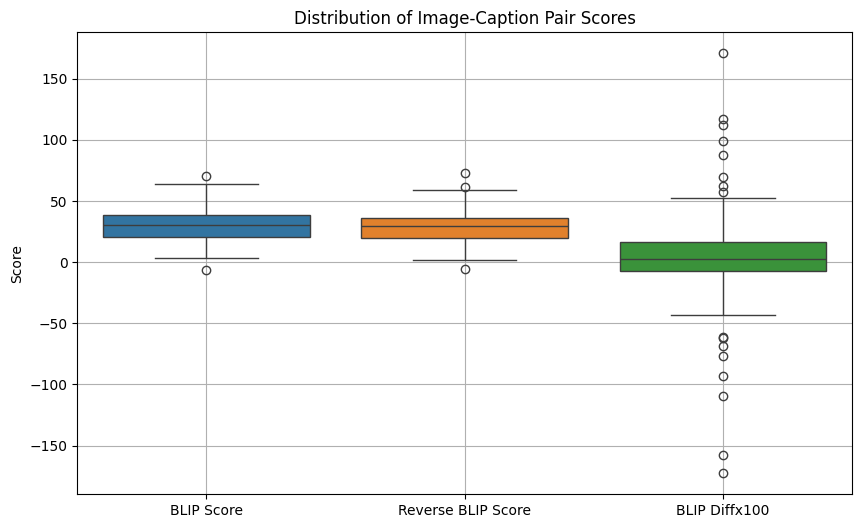

BLIP Score: Avrage:29.599721385266193 var: 191.6725290225851,  Reverse BLIP Score: avg:29.390548448008236 var:190.2652580414436,  BLIP Diff: avg:2.0917293725795645 var: 2182.2112689300234


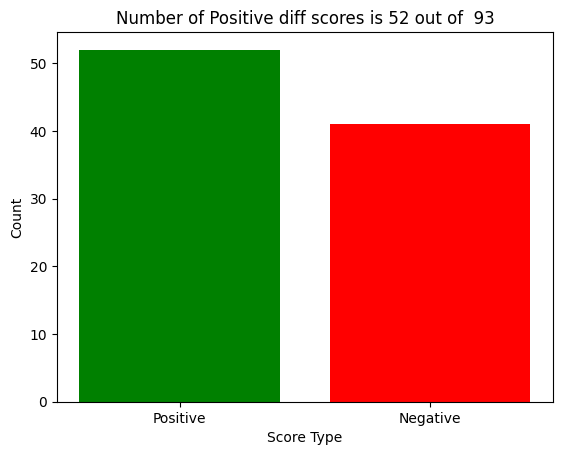

CSV file '/content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_winoground/blip_ouput.csv' created successfully.


In [ ]:
#base winoground evalauation
current_dir = f'/content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation'
base_winoground_dir = f'{current_dir}/base_evaluation_winoground'
base_winoground_json_file = f'{base_winoground_dir}/image_data.json'
evaluation(base_winoground_dir,base_winoground_json_file,metric ='blip', output_file_name = "blip_ouput")

#Evaluate our trained model using Benchmark list
This code use our trained model to generate images from our benchmark list It saved in json file the image name, caption and reverse caption (generated fro caption using the function we used in the dataset filtering)

In [ ]:
torch.cuda.empty_cache()


In [ ]:

current_dir = f'/content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation'
model_id = ["nadavo11/actions_model", "nadavo11/actions_model5","nadavo11/ImSitu_actions_model"]
captions_txt = f'{current_dir}/benchmark.txt'
bm_trained_json = [[None] * 4 for _ in range(len(model_id))]
trained_bm_dir = [[None] * 4 for _ in range(len(model_id))]
caption_csv = "none"
for j in range(len(model_id)):
  for i in range(4):
    seed_base =41
    trained_bm_dir[j][i] = f'{current_dir}/bm_trained_{j}_evaluation_{i}'
    bm_trained_json[j][i] = evaluate_model(model_id[j], captions_txt, trained_bm_dir[j][i], 'none',  seed = seed_base+i)


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Evaluating using cuda


/usr/local/lib/python3.10/dist-packages/thinc/shims/pytorch.py:114: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(self._mixed_precision):


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Evaluating using cuda


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Evaluating using cuda


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Evaluating using cuda


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Evaluating using cuda


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Evaluating using cuda


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Evaluating using cuda


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Evaluating using cuda


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Using cuda
Metric used is CLIP Score using cuda
Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/bm_trained_0_evaluation_0/image_0_seed_41.png, Caption: A dog giving a present to a man., CLIP Score: 30.4443359375, reverse caption A present givings a dog to a man., reverse score 27.5390625, diff*10 29.052734375
Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/bm_trained_0_evaluation_0/image_1_seed_41.png, Caption: A dolphin rescuing a swimmer., CLIP Score: 26.513671875, reverse caption A swimmer rescuings a dolphin., reverse score 25.2685546875, diff*10 12.451171875
Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/bm_trained_0_evaluation_0/image_3_seed_41.png, Caption: A soldier delivering a message to a pigeon., CLIP Score: 33.349609375, reverse caption A message deliverings a soldier to a pigeon., reverse score 31.7138671875, diff*10 16.357421875
Image: /content/drive/MyDrive/MSC/summ

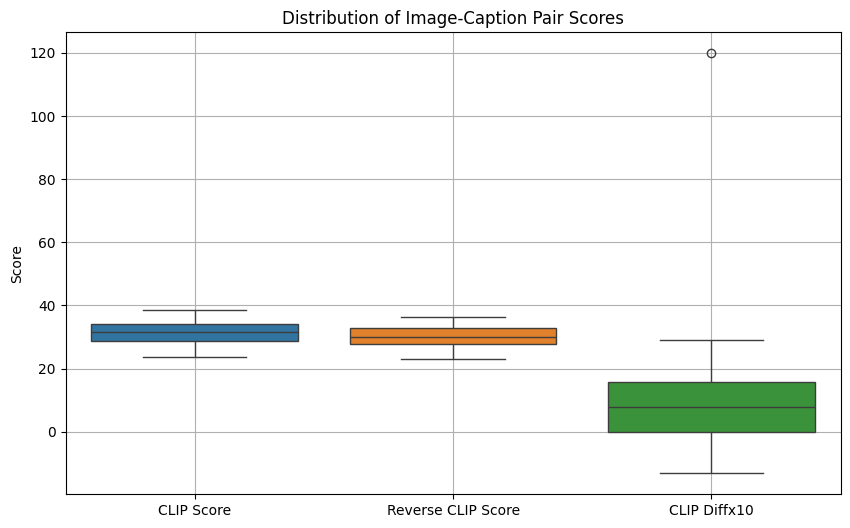

CLIP Score: Avrage:31.53957790798611 var: 16.154577426704364,  Reverse CLIP Score: avg:30.198160807291668 var:15.67834367354711,  CLIP Diff: avg:13.414171006944445 var: 802.4290020083204


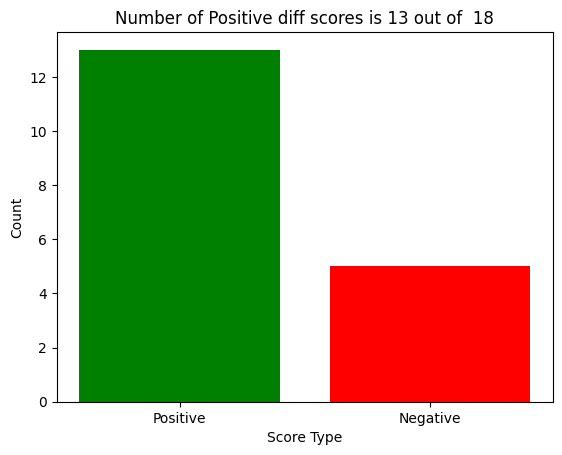

CSV file '/content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/bm_trained_0_evaluation_0/clip_output.csv' created successfully.
Using cuda
Metric used is CLIP Score using cuda
Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/bm_trained_0_evaluation_1/image_0_seed_42.png, Caption: A dog giving a present to a man., CLIP Score: 32.5927734375, reverse caption A present givings a dog to a man., reverse score 28.41796875, diff*10 41.748046875
Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/bm_trained_0_evaluation_1/image_1_seed_42.png, Caption: A dolphin rescuing a swimmer., CLIP Score: 28.5888671875, reverse caption A swimmer rescuings a dolphin., reverse score 27.197265625, diff*10 13.916015625
Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/bm_trained_0_evaluation_1/image_3_seed_42.png, Caption: A soldier delivering a message to a pigeon., CLIP Score: 26.611328125

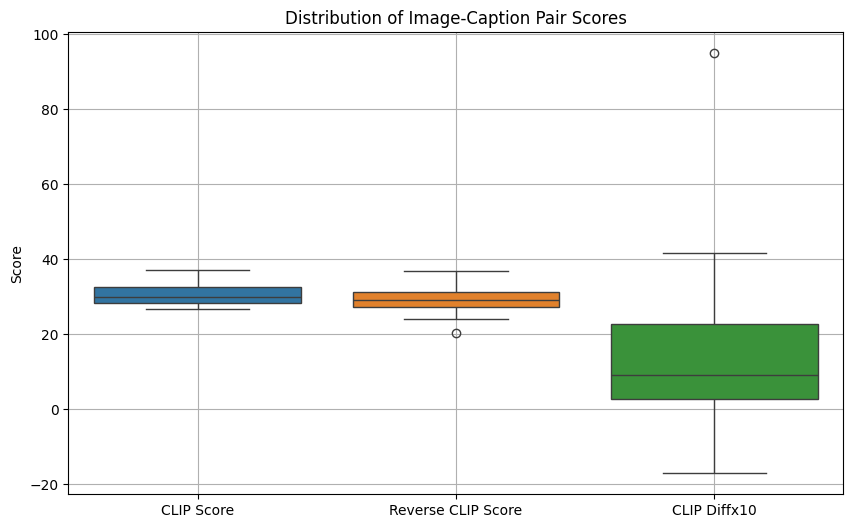

CLIP Score: Avrage:30.882432725694443 var: 9.213518581272643,  Reverse CLIP Score: avg:29.345703125 var:16.852302683724297,  CLIP Diff: avg:15.367296006944445 var: 537.9698158782205


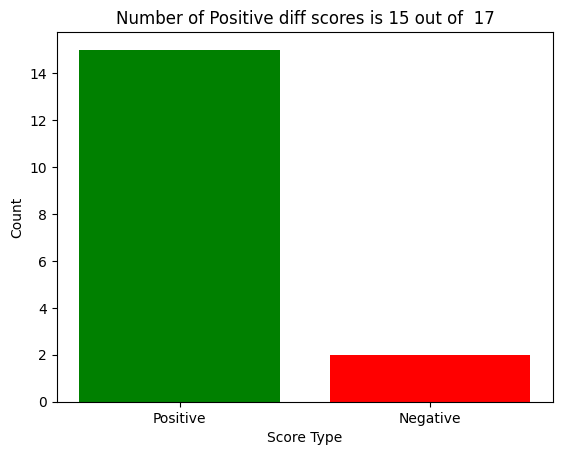

CSV file '/content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/bm_trained_0_evaluation_1/clip_output.csv' created successfully.
Using cuda
Metric used is CLIP Score using cuda
Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/bm_trained_0_evaluation_2/image_0_seed_43.png, Caption: A dog giving a present to a man., CLIP Score: 32.4462890625, reverse caption A present givings a dog to a man., reverse score 28.0029296875, diff*10 44.43359375
Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/bm_trained_0_evaluation_2/image_1_seed_43.png, Caption: A dolphin rescuing a swimmer., CLIP Score: 29.2236328125, reverse caption A swimmer rescuings a dolphin., reverse score 28.2470703125, diff*10 9.765625
Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/bm_trained_0_evaluation_2/image_3_seed_43.png, Caption: A soldier delivering a message to a pigeon., CLIP Score: 37.5244140625,

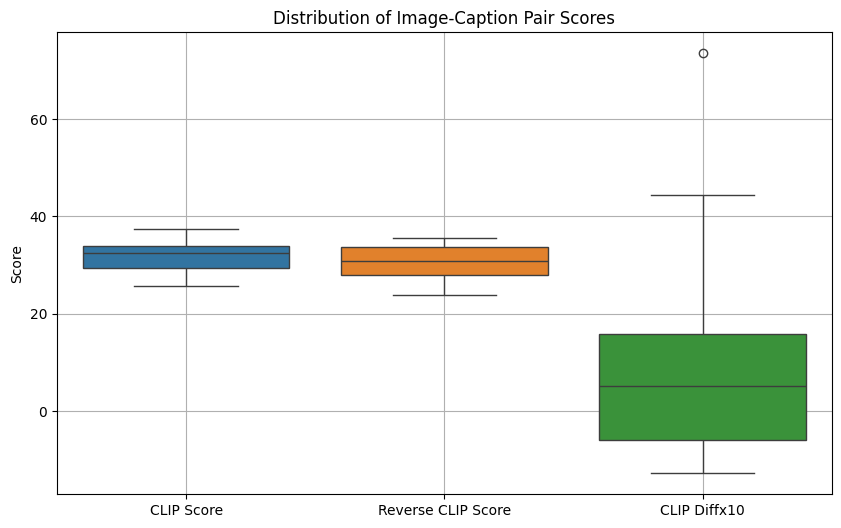

CLIP Score: Avrage:31.78168402777778 var: 10.201305518915625,  Reverse CLIP Score: avg:30.865478515625 var:12.725960049364302,  CLIP Diff: avg:9.162055121527779 var: 449.1946303550108


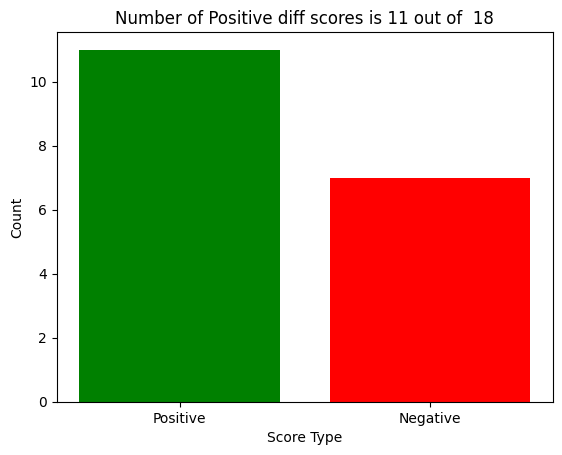

CSV file '/content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/bm_trained_0_evaluation_2/clip_output.csv' created successfully.
Using cuda
Metric used is CLIP Score using cuda
Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/bm_trained_0_evaluation_3/image_0_seed_44.png, Caption: A dog giving a present to a man., CLIP Score: 28.3203125, reverse caption A present givings a dog to a man., reverse score 27.197265625, diff*10 11.23046875
Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/bm_trained_0_evaluation_3/image_1_seed_44.png, Caption: A dolphin rescuing a swimmer., CLIP Score: 31.005859375, reverse caption A swimmer rescuings a dolphin., reverse score 30.5908203125, diff*10 4.150390625
Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/bm_trained_0_evaluation_3/image_3_seed_44.png, Caption: A soldier delivering a message to a pigeon., CLIP Score: 35.15625, revers

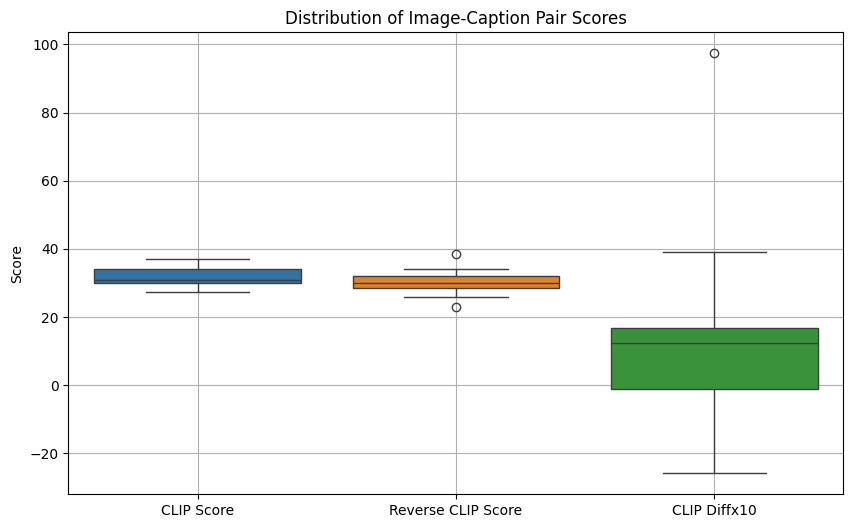

CLIP Score: Avrage:31.45751953125 var: 9.139130512873331,  Reverse CLIP Score: avg:30.164930555555557 var:11.193038504800679,  CLIP Diff: avg:12.925889756944445 var: 682.7677105679924


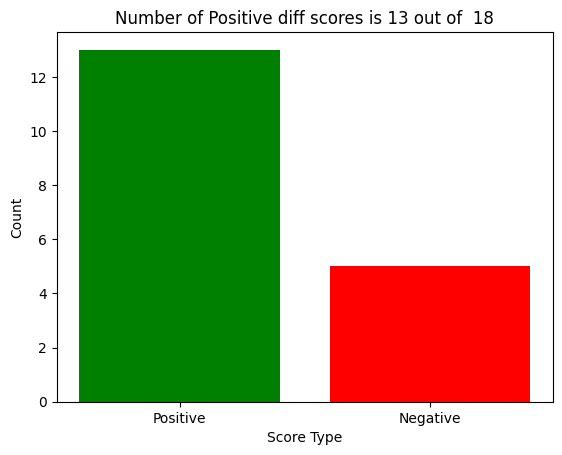

CSV file '/content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/bm_trained_0_evaluation_3/clip_output.csv' created successfully.
Using cuda
Metric used is CLIP Score using cuda
Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/bm_trained_1_evaluation_0/image_0_seed_41.png, Caption: A dog giving a present to a man., CLIP Score: 28.0517578125, reverse caption A present givings a dog to a man., reverse score 26.3427734375, diff*10 17.08984375
Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/bm_trained_1_evaluation_0/image_1_seed_41.png, Caption: A dolphin rescuing a swimmer., CLIP Score: 25.2685546875, reverse caption A swimmer rescuings a dolphin., reverse score 24.5361328125, diff*10 7.32421875
Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/bm_trained_1_evaluation_0/image_3_seed_41.png, Caption: A soldier delivering a message to a pigeon., CLIP Score: 35.083007812

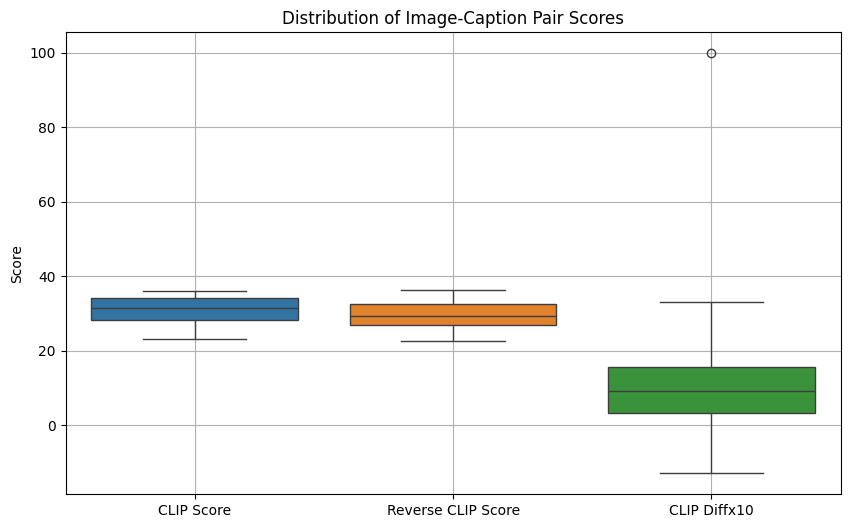

CLIP Score: Avrage:30.891248914930557 var: 14.867668994414958,  Reverse CLIP Score: avg:29.494222005208332 var:15.156803031762438,  CLIP Diff: avg:13.970269097222221 var: 529.3541852338815


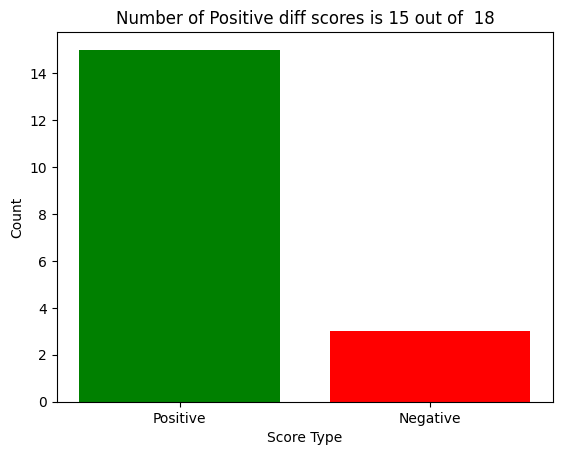

CSV file '/content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/bm_trained_1_evaluation_0/clip_output.csv' created successfully.
Using cuda
Metric used is CLIP Score using cuda
Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/bm_trained_1_evaluation_1/image_0_seed_42.png, Caption: A dog giving a present to a man., CLIP Score: 34.0576171875, reverse caption A present givings a dog to a man., reverse score 29.1259765625, diff*10 49.31640625
Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/bm_trained_1_evaluation_1/image_1_seed_42.png, Caption: A dolphin rescuing a swimmer., CLIP Score: 28.1494140625, reverse caption A swimmer rescuings a dolphin., reverse score 27.490234375, diff*10 6.591796875
Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/bm_trained_1_evaluation_1/image_3_seed_42.png, Caption: A soldier delivering a message to a pigeon., CLIP Score: 27.758789062

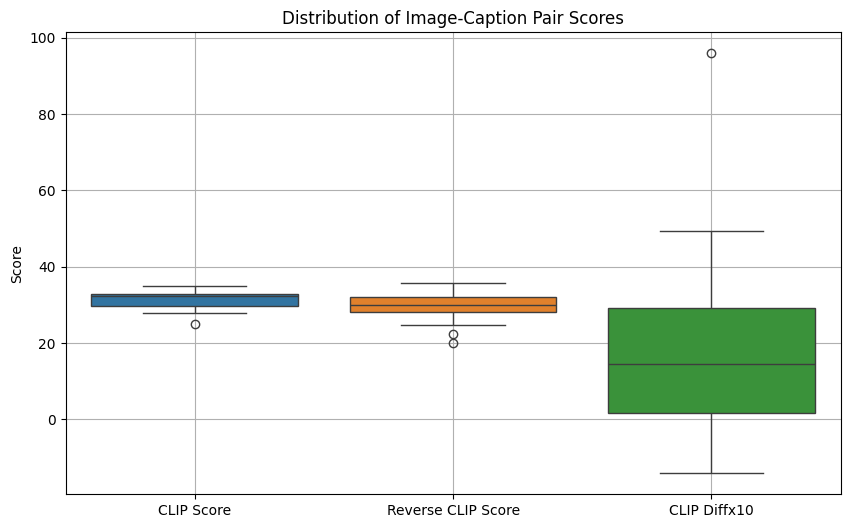

CLIP Score: Avrage:31.42768012152778 var: 6.708224982391169,  Reverse CLIP Score: avg:29.57695855034722 var:15.161906219558952,  CLIP Diff: avg:18.507215711805557 var: 661.2558147789518


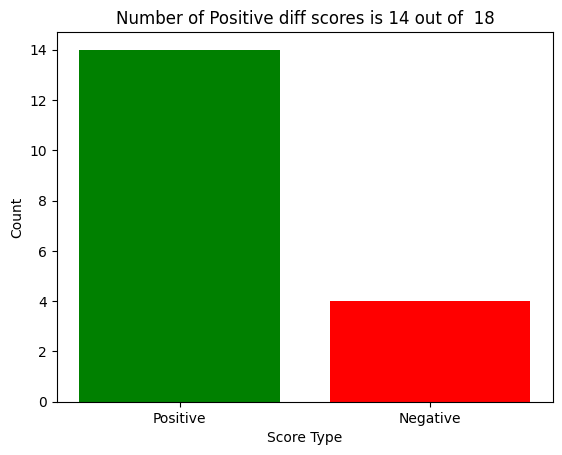

CSV file '/content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/bm_trained_1_evaluation_1/clip_output.csv' created successfully.
Using cuda
Metric used is CLIP Score using cuda
Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/bm_trained_1_evaluation_2/image_0_seed_43.png, Caption: A dog giving a present to a man., CLIP Score: 28.7353515625, reverse caption A present givings a dog to a man., reverse score 24.52392578125, diff*10 42.1142578125
Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/bm_trained_1_evaluation_2/image_1_seed_43.png, Caption: A dolphin rescuing a swimmer., CLIP Score: 30.56640625, reverse caption A swimmer rescuings a dolphin., reverse score 28.9794921875, diff*10 15.869140625
Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/bm_trained_1_evaluation_2/image_3_seed_43.png, Caption: A soldier delivering a message to a pigeon., CLIP Score: 37.5, rev

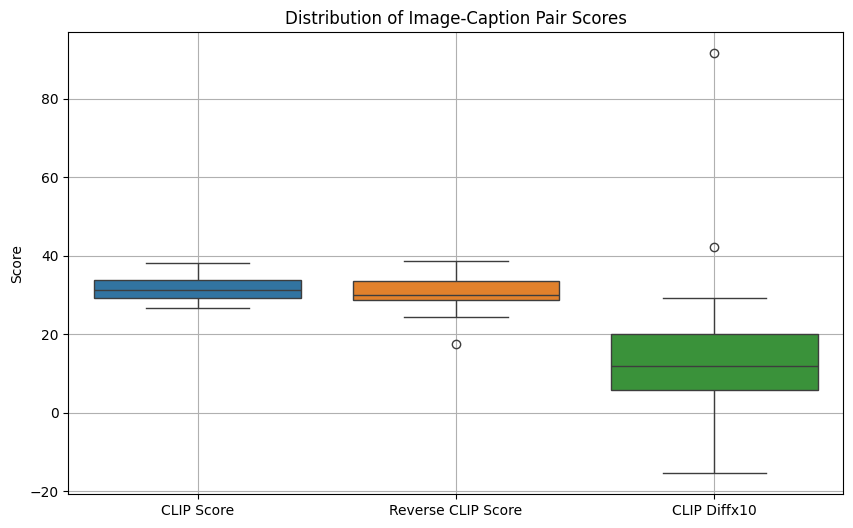

CLIP Score: Avrage:31.858995225694443 var: 9.995399065959601,  Reverse CLIP Score: avg:30.27004665798611 var:20.752579065752617,  CLIP Diff: avg:15.889485677083334 var: 516.0110692183177


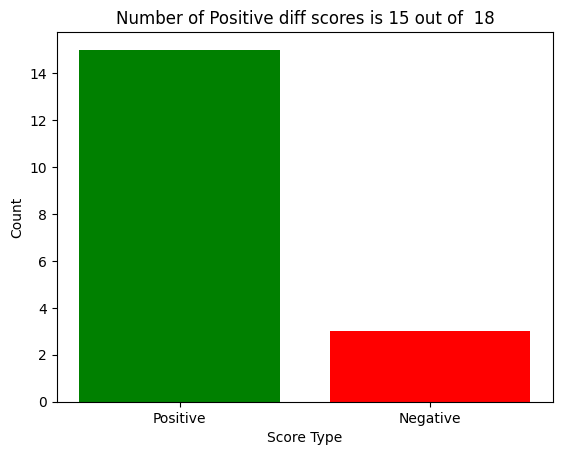

CSV file '/content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/bm_trained_1_evaluation_2/clip_output.csv' created successfully.
Using cuda
Metric used is CLIP Score using cuda
Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/bm_trained_1_evaluation_3/image_0_seed_44.png, Caption: A dog giving a present to a man., CLIP Score: 28.6376953125, reverse caption A present givings a dog to a man., reverse score 26.0986328125, diff*10 25.390625
Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/bm_trained_1_evaluation_3/image_1_seed_44.png, Caption: A dolphin rescuing a swimmer., CLIP Score: 28.5888671875, reverse caption A swimmer rescuings a dolphin., reverse score 27.587890625, diff*10 10.009765625
Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/bm_trained_1_evaluation_3/image_3_seed_44.png, Caption: A soldier delivering a message to a pigeon., CLIP Score: 33.8623046875

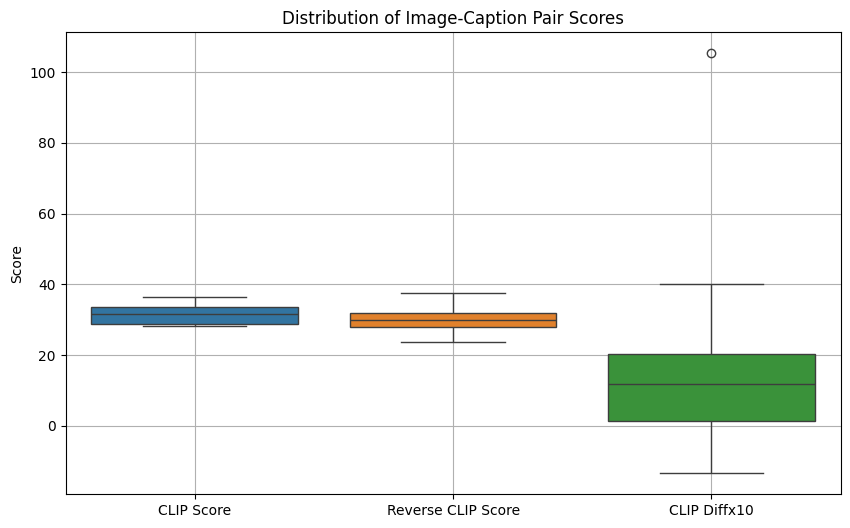

CLIP Score: Avrage:31.70844184027778 var: 7.623205950230728,  Reverse CLIP Score: avg:30.131700303819443 var:11.456760083451682,  CLIP Diff: avg:15.767415364583334 var: 667.2644780741798


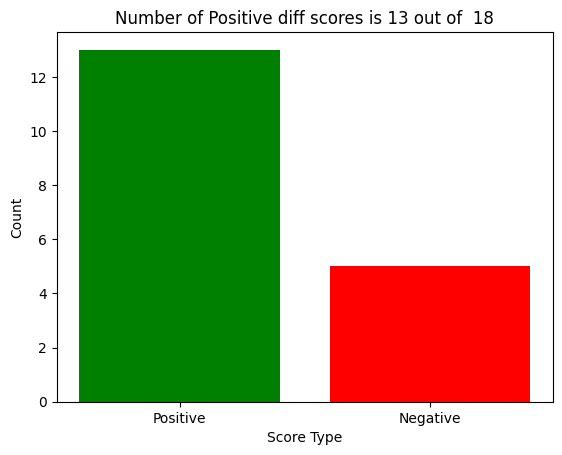

CSV file '/content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/bm_trained_1_evaluation_3/clip_output.csv' created successfully.
Using cuda
Metric used is CLIP Score using cuda
Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/bm_trained_2_evaluation_0/image_0_seed_41.png, Caption: A dog giving a present to a man., CLIP Score: 33.3984375, reverse caption A present givings a dog to a man., reverse score 29.8095703125, diff*10 35.888671875
Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/bm_trained_2_evaluation_0/image_1_seed_41.png, Caption: A dolphin rescuing a swimmer., CLIP Score: 28.2958984375, reverse caption A swimmer rescuings a dolphin., reverse score 26.9287109375, diff*10 13.671875
Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/bm_trained_2_evaluation_0/image_3_seed_41.png, Caption: A soldier delivering a message to a pigeon., CLIP Score: 37.5244140625, 

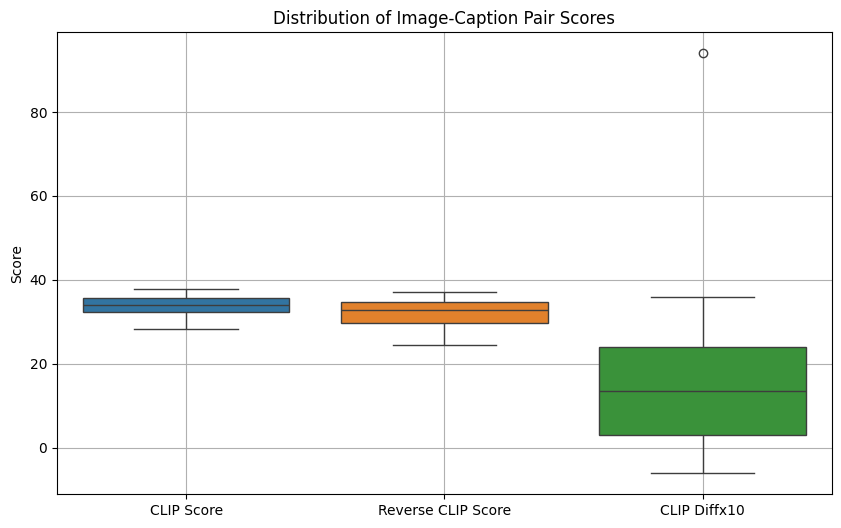

CLIP Score: Avrage:33.59239366319444 var: 8.084474154460576,  Reverse CLIP Score: avg:31.907823350694443 var:12.393823744338238,  CLIP Diff: avg:16.845703125 var: 482.7843772040473


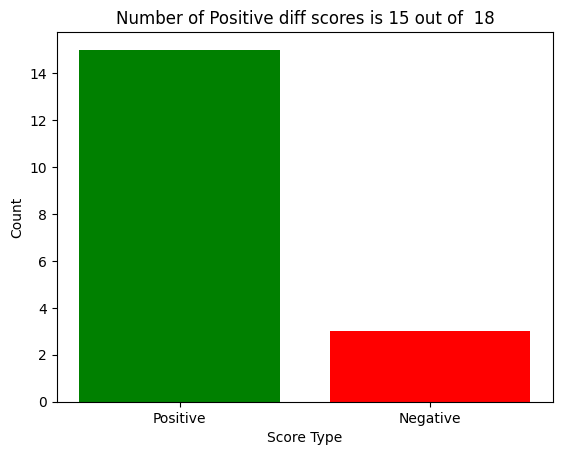

CSV file '/content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/bm_trained_2_evaluation_0/clip_output.csv' created successfully.
Using cuda
Metric used is CLIP Score using cuda
Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/bm_trained_2_evaluation_1/image_0_seed_42.png, Caption: A dog giving a present to a man., CLIP Score: 31.8115234375, reverse caption A present givings a dog to a man., reverse score 29.0771484375, diff*10 27.34375
Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/bm_trained_2_evaluation_1/image_1_seed_42.png, Caption: A dolphin rescuing a swimmer., CLIP Score: 29.2724609375, reverse caption A swimmer rescuings a dolphin., reverse score 27.8564453125, diff*10 14.16015625
Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/bm_trained_2_evaluation_1/image_3_seed_42.png, Caption: A soldier delivering a message to a pigeon., CLIP Score: 37.890625, rev

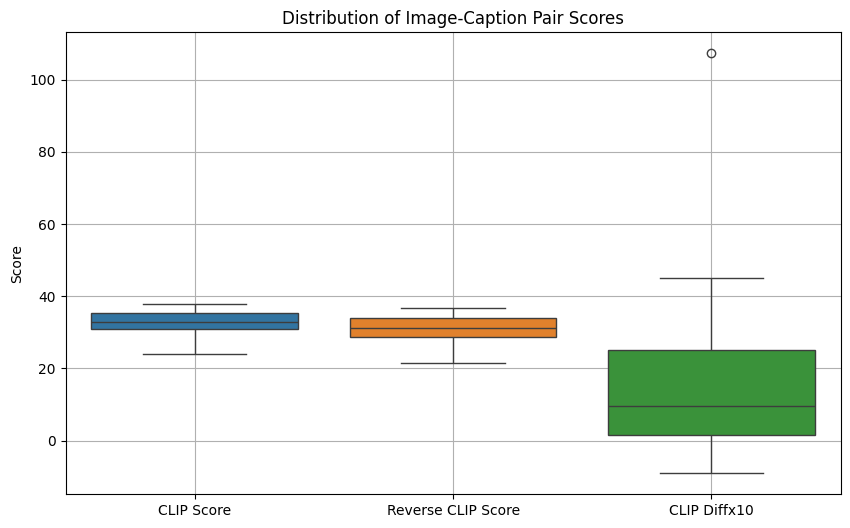

CLIP Score: Avrage:32.86810980902778 var: 11.670444114708607,  Reverse CLIP Score: avg:31.18625217013889 var:16.466007556444332,  CLIP Diff: avg:16.81857638888889 var: 670.629335038456


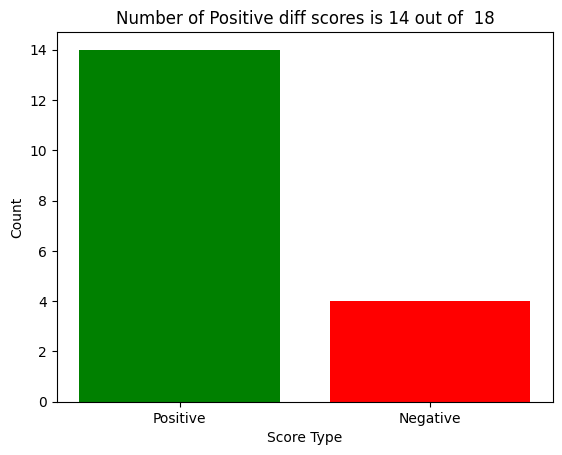

CSV file '/content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/bm_trained_2_evaluation_1/clip_output.csv' created successfully.
Using cuda
Metric used is CLIP Score using cuda
Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/bm_trained_2_evaluation_2/image_0_seed_43.png, Caption: A dog giving a present to a man., CLIP Score: 28.9794921875, reverse caption A present givings a dog to a man., reverse score 27.44140625, diff*10 15.380859375
Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/bm_trained_2_evaluation_2/image_1_seed_43.png, Caption: A dolphin rescuing a swimmer., CLIP Score: 28.515625, reverse caption A swimmer rescuings a dolphin., reverse score 26.7822265625, diff*10 17.333984375
Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/bm_trained_2_evaluation_2/image_3_seed_43.png, Caption: A soldier delivering a message to a pigeon., CLIP Score: 36.474609375, r

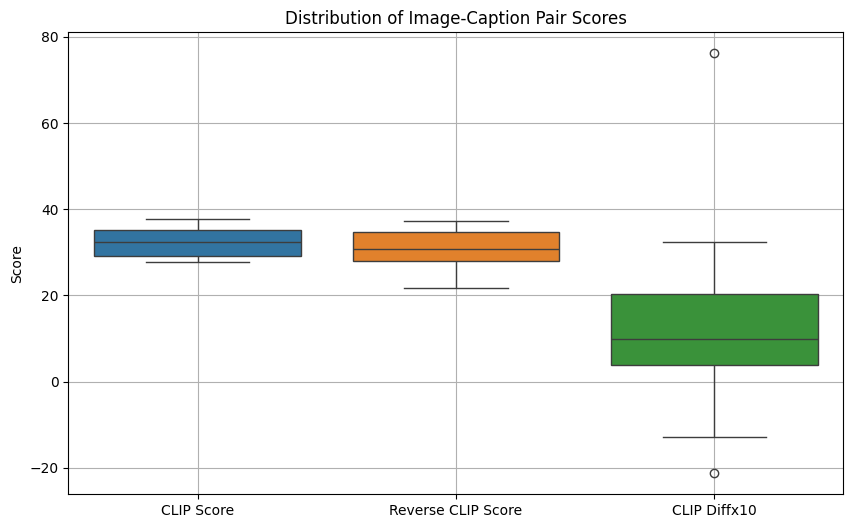

CLIP Score: Avrage:32.283528645833336 var: 10.284251636928984,  Reverse CLIP Score: avg:31.034342447916668 var:15.658090511957802,  CLIP Diff: avg:12.491861979166666 var: 410.1941982905071


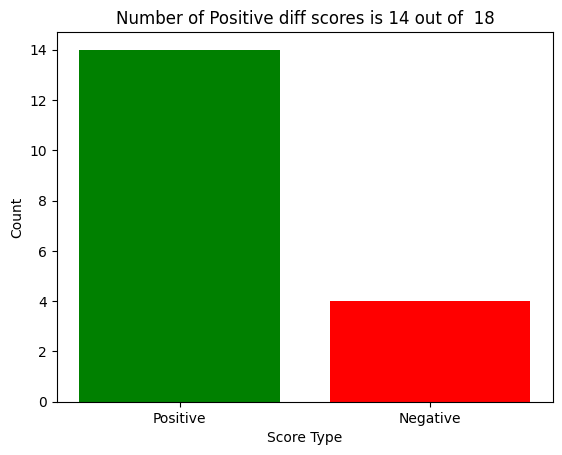

CSV file '/content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/bm_trained_2_evaluation_2/clip_output.csv' created successfully.
Using cuda
Metric used is CLIP Score using cuda
Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/bm_trained_2_evaluation_3/image_0_seed_44.png, Caption: A dog giving a present to a man., CLIP Score: 29.4677734375, reverse caption A present givings a dog to a man., reverse score 28.0029296875, diff*10 14.6484375
Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/bm_trained_2_evaluation_3/image_1_seed_44.png, Caption: A dolphin rescuing a swimmer., CLIP Score: 28.369140625, reverse caption A swimmer rescuings a dolphin., reverse score 27.197265625, diff*10 11.71875
Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/bm_trained_2_evaluation_3/image_3_seed_44.png, Caption: A soldier delivering a message to a pigeon., CLIP Score: 38.3544921875, re

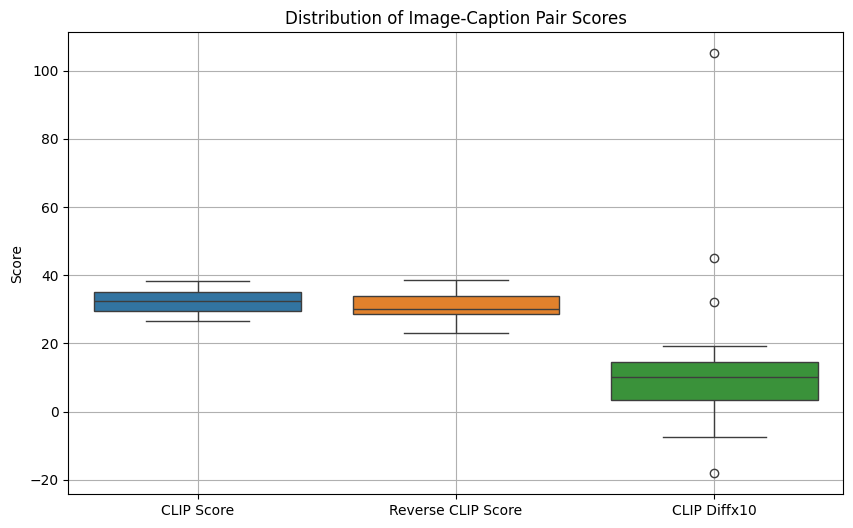

CLIP Score: Avrage:32.53309461805556 var: 12.71487754068257,  Reverse CLIP Score: avg:31.07842339409722 var:16.910110450821158,  CLIP Diff: avg:14.546712239583334 var: 671.1255345079635


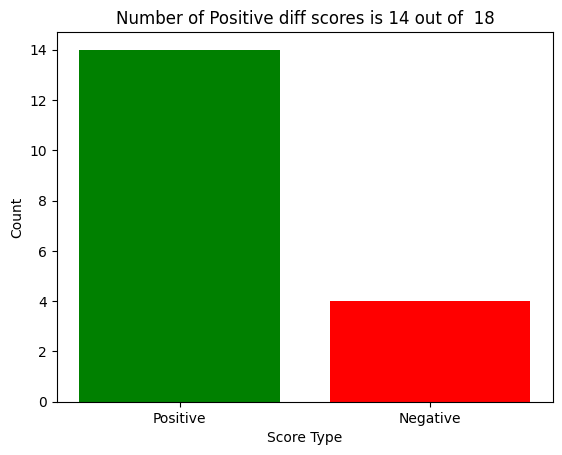

CSV file '/content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/bm_trained_2_evaluation_3/clip_output.csv' created successfully.


In [50]:
current_dir = f'/content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation'
model_id = ["nadavo11/actions_model", "nadavo11/actions_model5","nadavo11/ImSitu_actions_model"]
captions_txt = f'{current_dir}/benchmark.txt'
bm_trained_json = [[None] * 4 for _ in range(len(model_id))]
trained_bm_dir = [[None] * 4 for _ in range(len(model_id))]
caption_csv = "none"
for j in range(len(model_id)):
  for i in range(4):
    seed_base =41
    trained_bm_dir[j][i] = f'{current_dir}/bm_trained_{j}_evaluation_{i}'
    bm_trained_json[j][i] = f'{trained_bm_dir[j][i]}/image_data.json'
    evaluation(trained_bm_dir[j][i],bm_trained_json[j][i],metric ='clip')

In [ ]:
current_dir = f'/content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation'
model_id = ["nadavo11/actions_model", "nadavo11/actions_model5","nadavo11/ImSitu_actions_model"]
captions_txt = f'{current_dir}/benchmark.txt'
bm_trained_json = [[None] * 4 for _ in range(len(model_id))]
trained_bm_dir = [[None] * 4 for _ in range(len(model_id))]
caption_csv = "none"
for j in range(len(model_id)):
  for i in range(4):
    seed_base =41
    trained_bm_dir[j][i] = f'{current_dir}/bm_trained_{j}_evaluation_{i}'
    bm_trained_json[j][i] = f'{trained_bm_dir[j][i]}/image_data.json'
    evaluation(trained_bm_dir[j][i],bm_trained_json[j][i],metric ='blip', output_file_name = "blip_ouput")


#Evaluate trained model using winoground captions
This code use our trained model to generate images captions we considered as "interasting" from winoground
It saved in json file the image name, caption and reverse caption (generated fro caption using the function we used in the dataset filtering)

In [ ]:

current_dir = f'/content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation'
winoground_captions_csv_file = f"{current_dir}/winoground_filtering_output.csv"
model_id = ["nadavo11/actions_model", "nadavo11/actions_model5","nadavo11/ImSitu_actions_model"]
winoground_trained_dir = [None]  * len(model_id)
winoground_trained_json = [None] * len(model_id)

captions_txt_none = "none"
for j in range(len(model_id)):
  seed_base =42
  winoground_trained_dir[j] = f'{current_dir}/winoground_trained_{j}_evaluation'
  winoground_trained_json[j] = evaluate_model(model_id[j], captions_txt_none, winoground_trained_dir[j], winoground_captions_csv_file,  seed = seed_base)


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Evaluating using cuda


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Evaluating using cuda


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

In [ ]:
current_dir = f'/content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation'
model_id = ["nadavo11/actions_model", "nadavo11/actions_model5", "nadavo11/ImSitu_actions_model"]
winoground_trained_dir = [None]  * len(model_id)
winoground_trained_json = [None] * len(model_id)
for j in range(len(model_id)):
  winoground_trained_dir[j] = f'{current_dir}/winoground_trained_{j}_evaluation'
  winoground_trained_json[j] = f'{winoground_trained_dir[j]}/image_data.json'
  evaluation(winoground_trained_dir[j],winoground_trained_json[j],metric ='clip')


In [ ]:
!pip install --upgrade transformers

  Using cached transformers-4.45.1-py3-none-any.whl.metadata (44 kB)
  Using cached tokenizers-0.20.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.7 kB)
Using cached transformers-4.45.1-py3-none-any.whl (9.9 MB)
Using cached tokenizers-0.20.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (2.9 MB)
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.15.2
    Uninstalling tokenizers-0.15.2:
      Successfully uninstalled tokenizers-0.15.2
  Attempting uninstall: transformers
    Found existing installation: transformers 4.36.2
    Uninstalling transformers-4.36.2:
      Successfully uninstalled transformers-4.36.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
spacy-transformers 1.3.5 requires transformers<4.37.0,>=3.4.0, but you have transformers 4.45.1 which is incompatible.


In [ ]:
current_dir = f'/content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation'
model_id = ["nadavo11/actions_model", "nadavo11/actions_model5","nadavo11/ImSitu_actions_model"]
winoground_trained_dir = [None]  * len(model_id)
winoground_trained_json = [None] * len(model_id)
for j in range(len(model_id)):
  winoground_trained_dir[j] = f'{current_dir}/winoground_trained_{j}_evaluation'
  winoground_trained_json[j] = f'{winoground_trained_dir[j]}/image_data.json'
  evaluation(winoground_trained_dir[j],winoground_trained_json[j],metric ='blip', output_file_name = "blip_ouput")